In [7]:
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import sys

In [4]:
def encode_lable(y, num_classes):
    y_gt = np.zeros((len(y), num_classes))
    for i in range(0, len(y)):
        y_gt[i, y[i]] = 1
    return y_gt

In [79]:
def h(theta, X):
    return 1.0 / (1 + np.exp(-np.dot(X, theta)))

In [6]:
def sigm_derivative(theta, X):
    return h(theta, X) * (1 - h(theta, X))

In [8]:
def loss(y_gt, y_pred):
    cross_entropy_error = 0.0
    for i in range(0, len(y_gt)):
        for j in range(0, len(y_gt[i])):
            cross_entropy_error -= (y_gt[i][j] * np.log(y_pred[i][j]) + (1 - y_gt[i][j]) * np.log(1 - y_pred[i][j]))
    return cross_entropy_error / len(y_gt)

In [9]:
def CEderivative(X, y_gt, y_pred):
    return np.dot(y_pred - y_gt, X) / len(y_gt)

In [109]:
def acc(y_test, y_out):
    accuracy = 0
    for i in range(len(y_out)):
        if np.argmax(y_test[i]) == np.argmax(y_out[i]):
            accuracy += 1
    return accuracy / len(y_test)

In [230]:
def RSMprob(Et_1, g, gamma, mu, e):
    Et = (gamma*Et_1) + (1-gamma)*(g**2)
    delta = (mu)/np.sqrt(Et + e)
    delta*=g
    return delta 

In [176]:
def forward(thetas, X, dropout_prob, train_test_check):
    num_layers = thetas.shape[0]
    outs = []
    for t in range(0, num_layers): #проходим по всем слоям (все слои с сигмоидальной функцией активации)
        if t == 0:
            outs.append(np.array([h(thetas[t][:, i], X) for i in range(0, thetas[t].shape[1])]).T)
        else:
            outs.append(np.array([h(thetas[t][:, i], np.asarray(outs[t-1])) for i in range(0, thetas[t].shape[1])]).T)
    #Dropout
    if train_test_check:
        for i in range(len(outs) - 1):#для всех слоев кроме выходного и входного
            for o in outs[i]:
                o *= np.random.binomial(1,dropout_prob,o.shape[0]) * (1) / (1 - dropout_prob)
    return [out for out in outs]

In [192]:
def backward(X, y_gt, thetas, dropout_prob):
    num_features = X.shape[1]
    num_classes = y_gt.shape[1]
    outs = forward(thetas, X,dropout_prob, True)
    num_layers = len(outs)
    d_theta = []
    d_theta.append(np.zeros([num_features, outs[0].shape[1]]))
    for i in range(0, num_layers - 1):
        d_theta.append(np.zeros([outs[i].shape[1], outs[i+1].shape[1]]))
    tmp_th = None
    #скрытые слои
    for i in range(len(outs) - 1, -1, -1):
        if i == len(outs) - 1:#выходной слой
            for class_no in range(0, num_classes):
                d_theta[i][:, class_no] = CEderivative(outs[i-1], y_gt[:, class_no], outs[i][:, class_no])
            tmp_th = outs[i] - y_gt
        elif i == 0:#первый скрытый
            tmp_th = np.dot(tmp_th, thetas[1].T)
            tmp_th = tmp_th * sigm_derivative(thetas[0], X)
            d_theta[0] = np.dot(X.T, tmp_th)
            d_theta[0] = d_theta[0]/outs[0].shape[0]
        else:# остальные скрытые
            tmp_th = np.dot(tmp_th, thetas[i+1].T)
            tmp_th = tmp_th * sigm_derivative(thetas[i], outs[i-1])
            d_theta[i] = np.dot(outs[i-1].T, tmp_th)
            d_theta[i] = d_theta[i]/outs[i].shape[0]
    return d_theta

In [90]:
(dx_train, dy_train), (x_test, y_test) = cifar10.load_data()

In [91]:
print('x_train shape:', dx_train.shape)
print(dx_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [92]:
dy_train = encode_lable(dy_train, 10)
y_test = encode_lable(y_test, 10)

In [93]:
dx_train = np.asarray([list(x.flat) for x in dx_train])
x_test = np.asarray([list(x.flat) for x in x_test])

In [94]:
p = np.random.permutation(dx_train.shape[0])
x_train = dx_train[p[0:int(len(dx_train)*0.8)], :]
y_train = dy_train[p[0:int(len(dx_train)*0.8)]]
x_val = dx_train[p[int(len(dx_train)*0.8):], :]
y_val = dy_train[p[int(len(dx_train)*0.8):]]
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (40000, 3072)
y_train shape: (40000, 10)
x_val shape: (10000, 3072)
y_val shape: (10000, 10)
x_test shape: (10000, 3072)
y_test shape: (10000, 10)


In [95]:
x_train = (x_train - np.mean(x_train, axis = 0)) / np.var(x_train, axis = 0)
x_val = (x_val - np.mean(x_val, axis = 0)) / np.var(x_val, axis = 0)
x_test = (x_test - np.mean(x_test, axis = 0)) / np.var(x_test, axis = 0)

Initial loss : 12.941028128599534


Epoch 0/600 ...........
Loss train: 3.4288961706495202 
Loss val: 3.433847951036409 
Train accuracy :  0.1195 
Validation accuracy :  0.1233
Alpha:  1


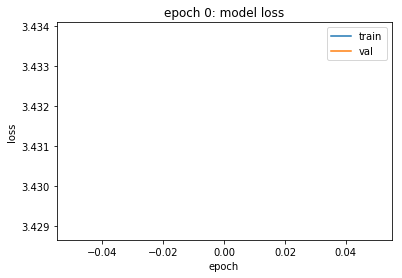

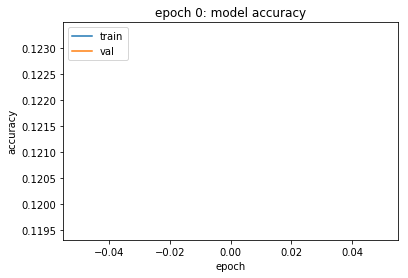



Epoch 1/600 ...........
Loss train: 3.328980780105586 
Loss val: 3.3339743586461896 
Train accuracy :  0.143125 
Validation accuracy :  0.1451
Alpha:  0.99


Epoch 2/600 ...........
Loss train: 3.267305895147582 
Loss val: 3.275930576380789 
Train accuracy :  0.16335 
Validation accuracy :  0.1648
Alpha:  0.9801


Epoch 3/600 ...........
Loss train: 3.216650265482587 
Loss val: 3.227209371790848 
Train accuracy :  0.1831 
Validation accuracy :  0.1816
Alpha:  0.9702989999999999


Epoch 4/600 ...........
Loss train: 3.1786323812265507 
Loss val: 3.189486878773847 
Train accuracy :  0.193575 
Validation accuracy :  0.1924
Alpha:  0.96059601


Epoch 5/600 ...........
Loss train: 3.1483357871943682 
Loss val: 3.160901424985751 
Train accuracy :  0.206125 
Validation accuracy :  0.2028
Alpha:  0.9509900498999999


Epoch 6/600 ...........
Loss train: 3.121520975144319 
Loss val: 3.1348534519089264 
Train accuracy :  0.21345 
Validation accuracy :  0.2115
Alpha:  0.9414801494009999


Epoch 

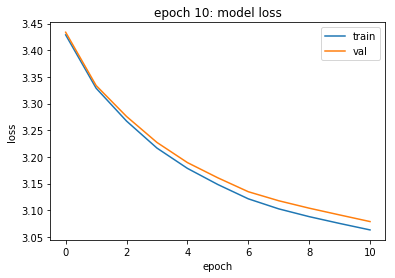

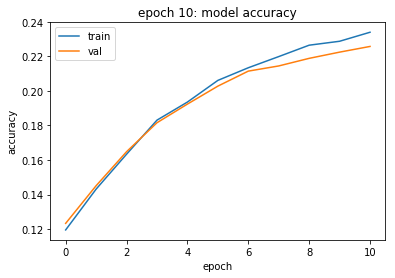



Epoch 11/600 ...........
Loss train: 3.0476849982410075 
Loss val: 3.063819841986697 
Train accuracy :  0.23945 
Validation accuracy :  0.2324
Alpha:  0.8953382542587163


Epoch 12/600 ...........
Loss train: 3.033136825513061 
Loss val: 3.0508893381417153 
Train accuracy :  0.242825 
Validation accuracy :  0.2347
Alpha:  0.8863848717161291


Epoch 13/600 ...........
Loss train: 3.0227771466382776 
Loss val: 3.0413461471412533 
Train accuracy :  0.245325 
Validation accuracy :  0.2345
Alpha:  0.8775210229989678


Epoch 14/600 ...........
Loss train: 3.0123097212453027 
Loss val: 3.030798474082398 
Train accuracy :  0.24965 
Validation accuracy :  0.2425
Alpha:  0.8687458127689781


Epoch 15/600 ...........
Loss train: 3.0048367915899385 
Loss val: 3.0244269244504105 
Train accuracy :  0.25135 
Validation accuracy :  0.244
Alpha:  0.8600583546412883


Epoch 16/600 ...........
Loss train: 2.9992530471700345 
Loss val: 3.0206161064808894 
Train accuracy :  0.2548 
Validation accuracy : 

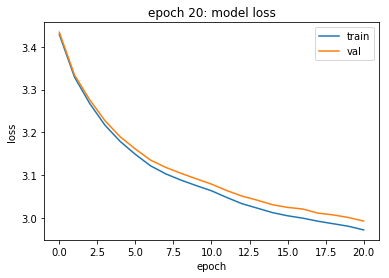

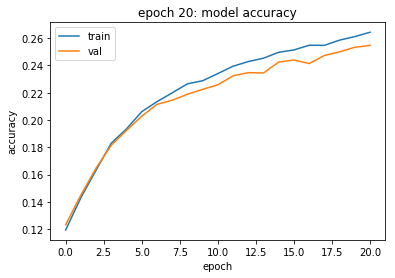



Epoch 21/600 ...........
Loss train: 2.9664133704050166 
Loss val: 2.9872164804682697 
Train accuracy :  0.26575 
Validation accuracy :  0.254
Alpha:  0.8097278682212583


Epoch 22/600 ...........
Loss train: 2.9596959180137854 
Loss val: 2.980465693056159 
Train accuracy :  0.268025 
Validation accuracy :  0.2594
Alpha:  0.8016305895390458


Epoch 23/600 ...........
Loss train: 2.9541744117073474 
Loss val: 2.97474555964057 
Train accuracy :  0.2696 
Validation accuracy :  0.26
Alpha:  0.7936142836436553


Epoch 24/600 ...........
Loss train: 2.949733181166191 
Loss val: 2.970591385156894 
Train accuracy :  0.27205 
Validation accuracy :  0.2591
Alpha:  0.7856781408072188


Epoch 25/600 ...........
Loss train: 2.945031957240082 
Loss val: 2.966408529421632 
Train accuracy :  0.271375 
Validation accuracy :  0.2632
Alpha:  0.7778213593991465


Epoch 26/600 ...........
Loss train: 2.9408392509709578 
Loss val: 2.963118875198343 
Train accuracy :  0.275325 
Validation accuracy :  0.267

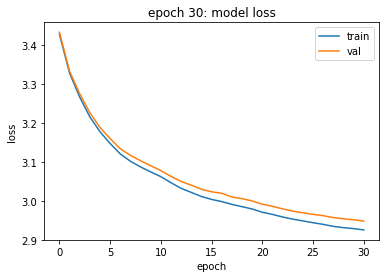

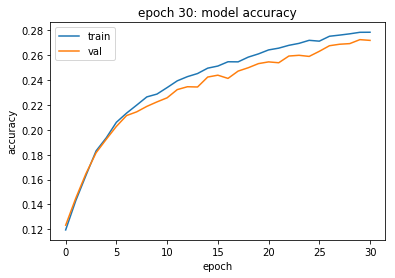



Epoch 31/600 ...........
Loss train: 2.9213128720638086 
Loss val: 2.9455350981742527 
Train accuracy :  0.28145 
Validation accuracy :  0.2717
Alpha:  0.7323033696543974


Epoch 32/600 ...........
Loss train: 2.91831581575648 
Loss val: 2.942729083141058 
Train accuracy :  0.2816 
Validation accuracy :  0.276
Alpha:  0.7249803359578534


Epoch 33/600 ...........
Loss train: 2.915015683822404 
Loss val: 2.9409539584004505 
Train accuracy :  0.28585 
Validation accuracy :  0.273
Alpha:  0.7177305325982748


Epoch 34/600 ...........
Loss train: 2.9138802668310086 
Loss val: 2.9387458928907892 
Train accuracy :  0.28345 
Validation accuracy :  0.2741
Alpha:  0.7105532272722921


Epoch 35/600 ...........
Loss train: 2.909791933643785 
Loss val: 2.9344970003109907 
Train accuracy :  0.2856 
Validation accuracy :  0.2723
Alpha:  0.7034476949995692


Epoch 36/600 ...........
Loss train: 2.9064098611919005 
Loss val: 2.9322429575791755 
Train accuracy :  0.28605 
Validation accuracy :  0.278

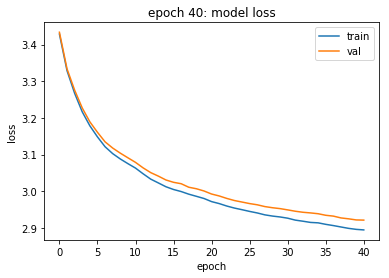

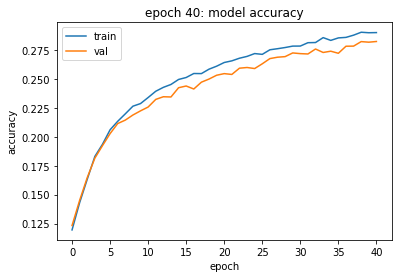



Epoch 41/600 ...........
Loss train: 2.891711004469953 
Loss val: 2.918240165962507 
Train accuracy :  0.292475 
Validation accuracy :  0.2835
Alpha:  0.6622820409839835


Epoch 42/600 ...........
Loss train: 2.8875070571037305 
Loss val: 2.915221787027393 
Train accuracy :  0.293925 
Validation accuracy :  0.2852
Alpha:  0.6556592205741436


Epoch 43/600 ...........
Loss train: 2.884810015104161 
Loss val: 2.913355972455139 
Train accuracy :  0.294 
Validation accuracy :  0.285
Alpha:  0.6491026283684022


Epoch 44/600 ...........
Loss train: 2.8818097933627906 
Loss val: 2.908483405399336 
Train accuracy :  0.29475 
Validation accuracy :  0.286
Alpha:  0.6426116020847181


Epoch 45/600 ...........
Loss train: 2.880914932969504 
Loss val: 2.9086948898322524 
Train accuracy :  0.29505 
Validation accuracy :  0.2852
Alpha:  0.6361854860638709


Epoch 46/600 ...........
Loss train: 2.8787690276304807 
Loss val: 2.905388578820566 
Train accuracy :  0.29595 
Validation accuracy :  0.2897

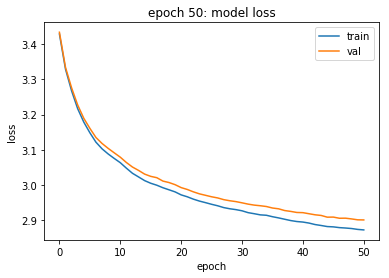

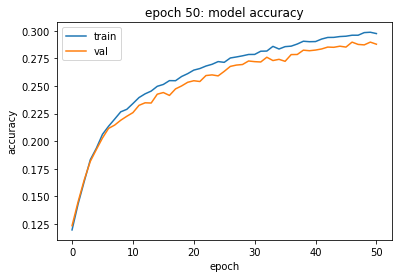



Epoch 51/600 ...........
Loss train: 2.870238800021882 
Loss val: 2.8982134278991785 
Train accuracy :  0.299425 
Validation accuracy :  0.2875
Alpha:  0.5989560064661611


Epoch 52/600 ...........
Loss train: 2.8672235325101756 
Loss val: 2.8958519305000188 
Train accuracy :  0.299875 
Validation accuracy :  0.2904
Alpha:  0.5929664464014994


Epoch 53/600 ...........
Loss train: 2.8667869542847146 
Loss val: 2.895025893895116 
Train accuracy :  0.301975 
Validation accuracy :  0.2907
Alpha:  0.5870367819374844


Epoch 54/600 ...........
Loss train: 2.8646058423101217 
Loss val: 2.893965348295406 
Train accuracy :  0.30145 
Validation accuracy :  0.2914
Alpha:  0.5811664141181095


Epoch 55/600 ...........
Loss train: 2.8627678757746655 
Loss val: 2.8927934728125035 
Train accuracy :  0.303025 
Validation accuracy :  0.291
Alpha:  0.5753547499769285


Epoch 56/600 ...........
Loss train: 2.86168803631524 
Loss val: 2.8898989928265673 
Train accuracy :  0.302375 
Validation accuracy 

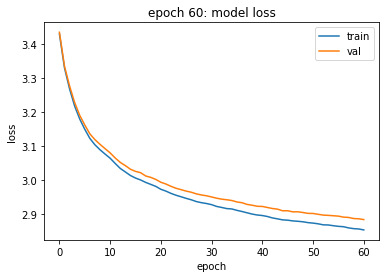

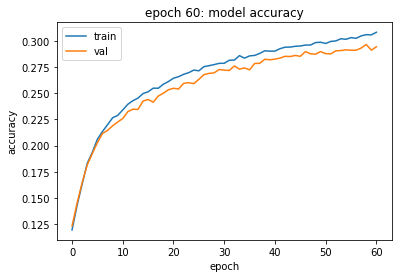



Epoch 61/600 ...........
Loss train: 2.8509517666708803 
Loss val: 2.8815409951932343 
Train accuracy :  0.306625 
Validation accuracy :  0.2953
Alpha:  0.5416850759668536


Epoch 62/600 ...........
Loss train: 2.8495131383676475 
Loss val: 2.8793709315825216 
Train accuracy :  0.307375 
Validation accuracy :  0.2946
Alpha:  0.536268225207185


Epoch 63/600 ...........
Loss train: 2.8491276431334835 
Loss val: 2.878821857183584 
Train accuracy :  0.30865 
Validation accuracy :  0.2952
Alpha:  0.5309055429551132


Epoch 64/600 ...........
Loss train: 2.8458817766485356 
Loss val: 2.876107036570514 
Train accuracy :  0.31005 
Validation accuracy :  0.298
Alpha:  0.525596487525562


Epoch 65/600 ...........
Loss train: 2.8445774315981405 
Loss val: 2.8745457497288096 
Train accuracy :  0.3099 
Validation accuracy :  0.2982
Alpha:  0.5203405226503064


Epoch 66/600 ...........
Loss train: 2.844623907811799 
Loss val: 2.874261828528011 
Train accuracy :  0.309625 
Validation accuracy :  0

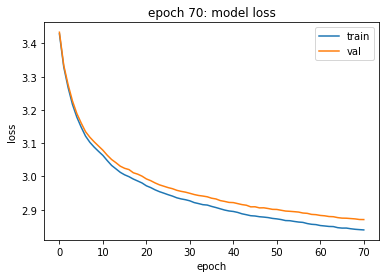

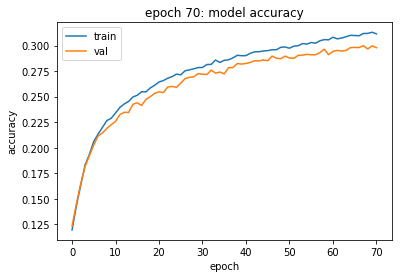



Epoch 71/600 ...........
Loss train: 2.837216914726397 
Loss val: 2.8682937789246346 
Train accuracy :  0.312825 
Validation accuracy :  0.2984
Alpha:  0.5


Epoch 72/600 ...........
Loss train: 2.8371402884809704 
Loss val: 2.8679034965970187 
Train accuracy :  0.3125 
Validation accuracy :  0.2987
Alpha:  0.5


Epoch 73/600 ...........
Loss train: 2.836073184295611 
Loss val: 2.8669699204121732 
Train accuracy :  0.3138 
Validation accuracy :  0.3008
Alpha:  0.5


Epoch 74/600 ...........
Loss train: 2.834914750039573 
Loss val: 2.8653833886768107 
Train accuracy :  0.3146 
Validation accuracy :  0.303
Alpha:  0.5


Epoch 75/600 ...........
Loss train: 2.8338948539651425 
Loss val: 2.865428463099082 
Train accuracy :  0.31455 
Validation accuracy :  0.3018
Alpha:  0.5


Epoch 76/600 ...........
Loss train: 2.8328677404221225 
Loss val: 2.8633743772669904 
Train accuracy :  0.315925 
Validation accuracy :  0.3001
Alpha:  0.5


Epoch 77/600 ...........
Loss train: 2.830894844486293 


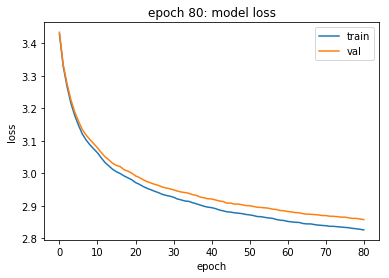

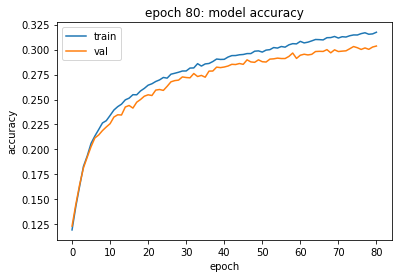



Epoch 81/600 ...........
Loss train: 2.8255321190551896 
Loss val: 2.8579596855058624 
Train accuracy :  0.317475 
Validation accuracy :  0.3028
Alpha:  0.5


Epoch 82/600 ...........
Loss train: 2.8243538974668425 
Loss val: 2.8568488104123513 
Train accuracy :  0.317675 
Validation accuracy :  0.3033
Alpha:  0.5


Epoch 83/600 ...........
Loss train: 2.8235124987443982 
Loss val: 2.8559726401812098 
Train accuracy :  0.3171 
Validation accuracy :  0.3018
Alpha:  0.5


Epoch 84/600 ...........
Loss train: 2.822688546703655 
Loss val: 2.8548098871976406 
Train accuracy :  0.3172 
Validation accuracy :  0.3029
Alpha:  0.5


Epoch 85/600 ...........
Loss train: 2.821798199032507 
Loss val: 2.853666589249705 
Train accuracy :  0.319975 
Validation accuracy :  0.3055
Alpha:  0.5


Epoch 86/600 ...........
Loss train: 2.8214437505327123 
Loss val: 2.854761508287503 
Train accuracy :  0.319025 
Validation accuracy :  0.3049
Alpha:  0.5


Epoch 87/600 ...........
Loss train: 2.8208307784027

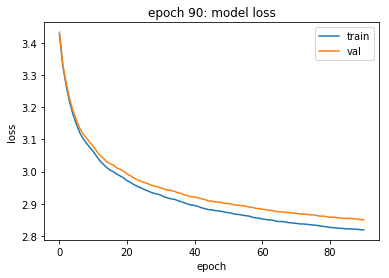

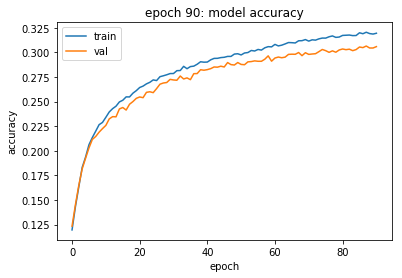



Epoch 91/600 ...........
Loss train: 2.816878828600376 
Loss val: 2.8491324380651535 
Train accuracy :  0.32015 
Validation accuracy :  0.3054
Alpha:  0.5


Epoch 92/600 ...........
Loss train: 2.8153340561969555 
Loss val: 2.847988261884276 
Train accuracy :  0.320575 
Validation accuracy :  0.3067
Alpha:  0.5


Epoch 93/600 ...........
Loss train: 2.814791747736745 
Loss val: 2.8472293989816526 
Train accuracy :  0.321425 
Validation accuracy :  0.3071
Alpha:  0.5


Epoch 94/600 ...........
Loss train: 2.813708518905173 
Loss val: 2.8468131721045693 
Train accuracy :  0.321625 
Validation accuracy :  0.3062
Alpha:  0.5


Epoch 95/600 ...........
Loss train: 2.812774217694344 
Loss val: 2.8452920094743184 
Train accuracy :  0.321575 
Validation accuracy :  0.3077
Alpha:  0.5


Epoch 96/600 ...........
Loss train: 2.8117446476220374 
Loss val: 2.844890592041424 
Train accuracy :  0.32175 
Validation accuracy :  0.308
Alpha:  0.5


Epoch 97/600 ...........
Loss train: 2.81115366673427

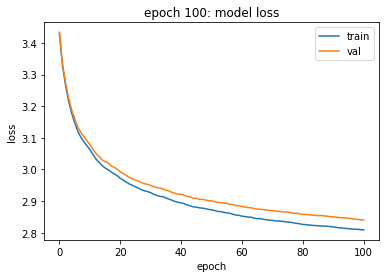

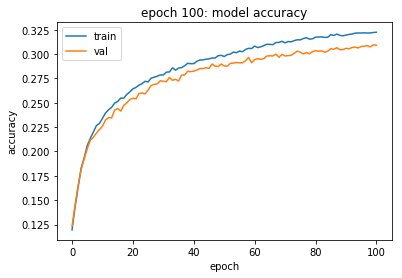



Epoch 101/600 ...........
Loss train: 2.8080721706341074 
Loss val: 2.84026125457174 
Train accuracy :  0.323575 
Validation accuracy :  0.3072
Alpha:  0.5


Epoch 102/600 ...........
Loss train: 2.807978411611133 
Loss val: 2.8400541724479424 
Train accuracy :  0.323875 
Validation accuracy :  0.3094
Alpha:  0.5


Epoch 103/600 ...........
Loss train: 2.807038022594159 
Loss val: 2.8398318800303404 
Train accuracy :  0.3248 
Validation accuracy :  0.309
Alpha:  0.5


Epoch 104/600 ...........
Loss train: 2.8053903100027986 
Loss val: 2.8388250876608803 
Train accuracy :  0.323925 
Validation accuracy :  0.31
Alpha:  0.5


Epoch 105/600 ...........
Loss train: 2.804431159107431 
Loss val: 2.8387851207622687 
Train accuracy :  0.324925 
Validation accuracy :  0.3111
Alpha:  0.5


Epoch 106/600 ...........
Loss train: 2.8032754359243057 
Loss val: 2.838021280423988 
Train accuracy :  0.32665 
Validation accuracy :  0.3113
Alpha:  0.5


Epoch 107/600 ...........
Loss train: 2.8029850251

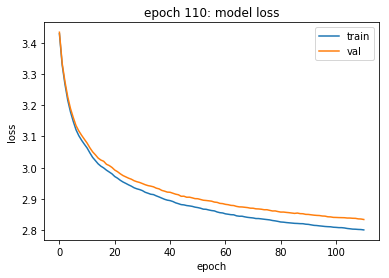

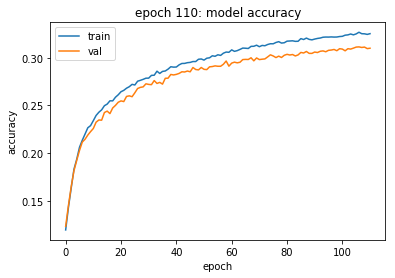



Epoch 111/600 ...........
Loss train: 2.8006526233911826 
Loss val: 2.834529025270063 
Train accuracy :  0.326325 
Validation accuracy :  0.3121
Alpha:  0.5


Epoch 112/600 ...........
Loss train: 2.7999247312062567 
Loss val: 2.833361425075839 
Train accuracy :  0.3264 
Validation accuracy :  0.3112
Alpha:  0.5


Epoch 113/600 ...........
Loss train: 2.7984401476060197 
Loss val: 2.8314533383095557 
Train accuracy :  0.326825 
Validation accuracy :  0.3127
Alpha:  0.5


Epoch 114/600 ...........
Loss train: 2.7974935477523792 
Loss val: 2.8315689668083963 
Train accuracy :  0.32815 
Validation accuracy :  0.3144
Alpha:  0.5


Epoch 115/600 ...........
Loss train: 2.797112125084479 
Loss val: 2.831002208608873 
Train accuracy :  0.3274 
Validation accuracy :  0.314
Alpha:  0.5


Epoch 116/600 ...........
Loss train: 2.7952439971767222 
Loss val: 2.8293559836234836 
Train accuracy :  0.3278 
Validation accuracy :  0.3124
Alpha:  0.5


Epoch 117/600 ...........
Loss train: 2.7946386671

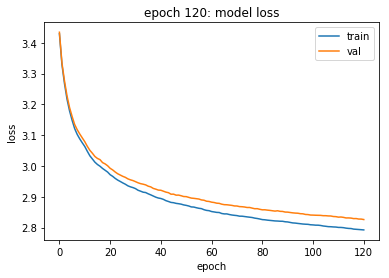

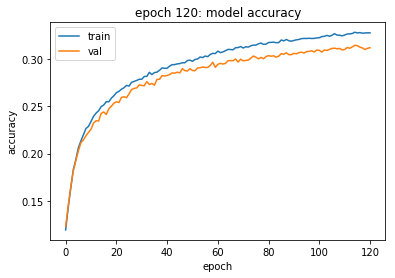



Epoch 121/600 ...........
Loss train: 2.793454117822638 
Loss val: 2.8291504496022304 
Train accuracy :  0.32885 
Validation accuracy :  0.314
Alpha:  0.5


Epoch 122/600 ...........
Loss train: 2.7917489856106115 
Loss val: 2.8260406532682207 
Train accuracy :  0.32775 
Validation accuracy :  0.3142
Alpha:  0.5


Epoch 123/600 ...........
Loss train: 2.7918730018002 
Loss val: 2.8262819805823285 
Train accuracy :  0.32875 
Validation accuracy :  0.3148
Alpha:  0.5


Epoch 124/600 ...........
Loss train: 2.791154936884804 
Loss val: 2.8260237071966587 
Train accuracy :  0.32915 
Validation accuracy :  0.3155
Alpha:  0.5


Epoch 125/600 ...........
Loss train: 2.7902542716559315 
Loss val: 2.82435336817317 
Train accuracy :  0.329425 
Validation accuracy :  0.3143
Alpha:  0.5


Epoch 126/600 ...........
Loss train: 2.7901679084631943 
Loss val: 2.8248828710640077 
Train accuracy :  0.328525 
Validation accuracy :  0.3129
Alpha:  0.5


Epoch 127/600 ...........
Loss train: 2.7893339760

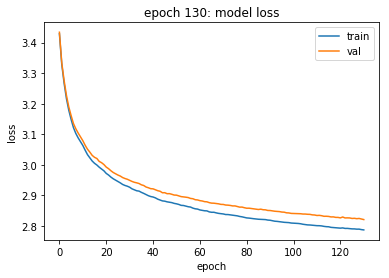

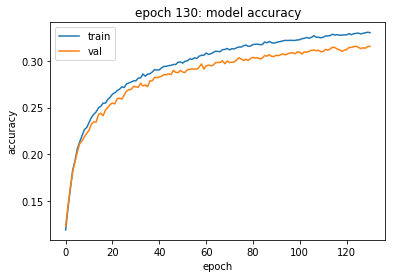



Epoch 131/600 ...........
Loss train: 2.7867010626898026 
Loss val: 2.8215143097213224 
Train accuracy :  0.330125 
Validation accuracy :  0.3154
Alpha:  0.5


Epoch 132/600 ...........
Loss train: 2.7865333890931057 
Loss val: 2.8212172449673307 
Train accuracy :  0.3318 
Validation accuracy :  0.3157
Alpha:  0.5


Epoch 133/600 ...........
Loss train: 2.784611102502362 
Loss val: 2.820184784265682 
Train accuracy :  0.3326 
Validation accuracy :  0.318
Alpha:  0.5


Epoch 134/600 ...........
Loss train: 2.784520446061744 
Loss val: 2.820441225655354 
Train accuracy :  0.332725 
Validation accuracy :  0.3182
Alpha:  0.5


Epoch 135/600 ...........
Loss train: 2.7850717469342965 
Loss val: 2.821094792243426 
Train accuracy :  0.33145 
Validation accuracy :  0.3163
Alpha:  0.5


Epoch 136/600 ...........
Loss train: 2.7835004897971443 
Loss val: 2.818465285721992 
Train accuracy :  0.33155 
Validation accuracy :  0.3171
Alpha:  0.5


Epoch 137/600 ...........
Loss train: 2.78232804728

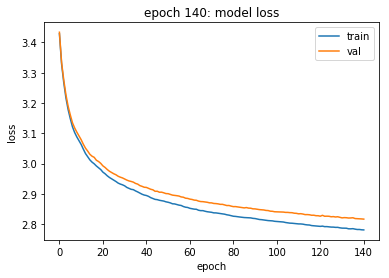

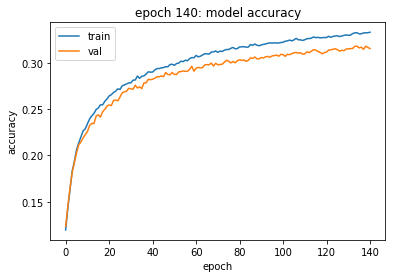



Epoch 141/600 ...........
Loss train: 2.7801470657902043 
Loss val: 2.816612842661414 
Train accuracy :  0.334025 
Validation accuracy :  0.3171
Alpha:  0.5


Epoch 142/600 ...........
Loss train: 2.779342854111135 
Loss val: 2.815871214564714 
Train accuracy :  0.334375 
Validation accuracy :  0.3152
Alpha:  0.5


Epoch 143/600 ...........
Loss train: 2.778543991005104 
Loss val: 2.8152082134055547 
Train accuracy :  0.334825 
Validation accuracy :  0.3172
Alpha:  0.5


Epoch 144/600 ...........
Loss train: 2.7789341437413815 
Loss val: 2.814848163525708 
Train accuracy :  0.3342 
Validation accuracy :  0.3172
Alpha:  0.5


Epoch 145/600 ...........
Loss train: 2.777728305955955 
Loss val: 2.8135528406797863 
Train accuracy :  0.333025 
Validation accuracy :  0.3175
Alpha:  0.5


Epoch 146/600 ...........
Loss train: 2.7769928931998247 
Loss val: 2.812523730033652 
Train accuracy :  0.334375 
Validation accuracy :  0.3199
Alpha:  0.5


Epoch 147/600 ...........
Loss train: 2.7746781

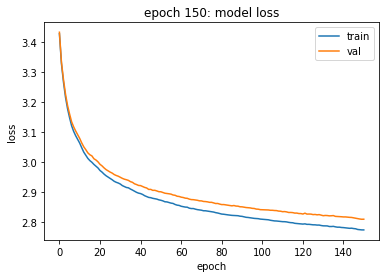

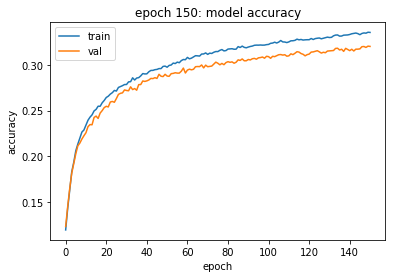



Epoch 151/600 ...........
Loss train: 2.7726341057121617 
Loss val: 2.808874679959492 
Train accuracy :  0.335825 
Validation accuracy :  0.3202
Alpha:  0.5


Epoch 152/600 ...........
Loss train: 2.771871982078546 
Loss val: 2.8097315122395177 
Train accuracy :  0.33635 
Validation accuracy :  0.321
Alpha:  0.5


Epoch 153/600 ...........
Loss train: 2.7706054732059617 
Loss val: 2.8072140805610792 
Train accuracy :  0.3359 
Validation accuracy :  0.3224
Alpha:  0.5


Epoch 154/600 ...........
Loss train: 2.7701073376472576 
Loss val: 2.806166715217214 
Train accuracy :  0.33485 
Validation accuracy :  0.3211
Alpha:  0.5


Epoch 155/600 ...........
Loss train: 2.7695748931798816 
Loss val: 2.8057112535565065 
Train accuracy :  0.33675 
Validation accuracy :  0.3233
Alpha:  0.5


Epoch 156/600 ...........
Loss train: 2.769165683725948 
Loss val: 2.8062829907391174 
Train accuracy :  0.33725 
Validation accuracy :  0.3207
Alpha:  0.5


Epoch 157/600 ...........
Loss train: 2.769761842

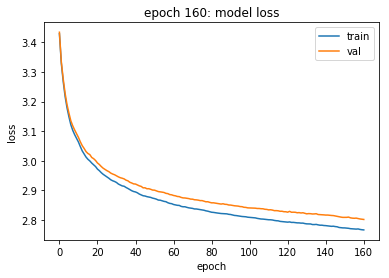

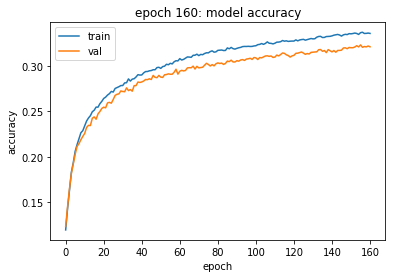



Epoch 161/600 ...........
Loss train: 2.7648562281533775 
Loss val: 2.801307003776283 
Train accuracy :  0.3371 
Validation accuracy :  0.3221
Alpha:  0.5


Epoch 162/600 ...........
Loss train: 2.7649191367118093 
Loss val: 2.8010645007239843 
Train accuracy :  0.337075 
Validation accuracy :  0.3206
Alpha:  0.5


Epoch 163/600 ...........
Loss train: 2.763898056053411 
Loss val: 2.800148934029973 
Train accuracy :  0.337475 
Validation accuracy :  0.3233
Alpha:  0.5


Epoch 164/600 ...........
Loss train: 2.764412620012758 
Loss val: 2.800376450000795 
Train accuracy :  0.338125 
Validation accuracy :  0.3232
Alpha:  0.5


Epoch 165/600 ...........
Loss train: 2.764472440667463 
Loss val: 2.7994011480350993 
Train accuracy :  0.336425 
Validation accuracy :  0.3229
Alpha:  0.5


Epoch 166/600 ...........
Loss train: 2.763233995648093 
Loss val: 2.7995591836576126 
Train accuracy :  0.33655 
Validation accuracy :  0.3211
Alpha:  0.5


Epoch 167/600 ...........
Loss train: 2.76269418

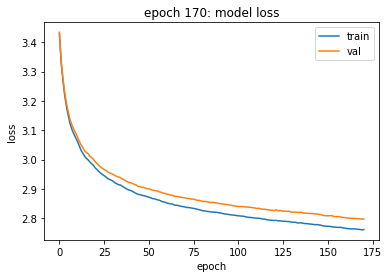

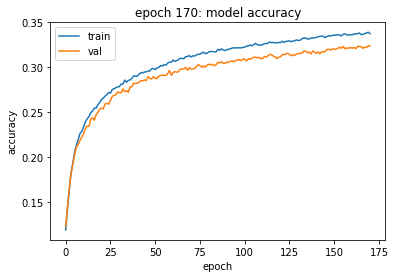



Epoch 171/600 ...........
Loss train: 2.761058633020474 
Loss val: 2.797305078895484 
Train accuracy :  0.339025 
Validation accuracy :  0.3247
Alpha:  0.5


Epoch 172/600 ...........
Loss train: 2.7612607668552536 
Loss val: 2.7969912819049636 
Train accuracy :  0.33865 
Validation accuracy :  0.3263
Alpha:  0.5


Epoch 173/600 ...........
Loss train: 2.7606234406332604 
Loss val: 2.7974745254930813 
Train accuracy :  0.3393 
Validation accuracy :  0.3246
Alpha:  0.5


Epoch 174/600 ...........
Loss train: 2.7589107320894763 
Loss val: 2.796103147233826 
Train accuracy :  0.340275 
Validation accuracy :  0.3253
Alpha:  0.5


Epoch 175/600 ...........
Loss train: 2.758111748330902 
Loss val: 2.795197406282824 
Train accuracy :  0.340275 
Validation accuracy :  0.3267
Alpha:  0.5


Epoch 176/600 ...........
Loss train: 2.7580918567701698 
Loss val: 2.7947316284544947 
Train accuracy :  0.339 
Validation accuracy :  0.326
Alpha:  0.5


Epoch 177/600 ...........
Loss train: 2.7579810397

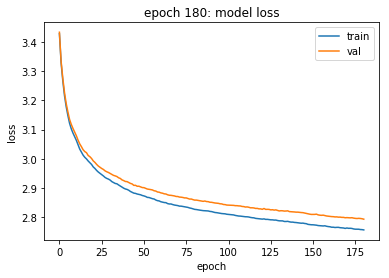

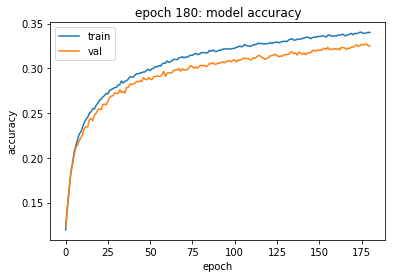



Epoch 181/600 ...........
Loss train: 2.7549462602902315 
Loss val: 2.792313473523613 
Train accuracy :  0.34105 
Validation accuracy :  0.3243
Alpha:  0.5


Epoch 182/600 ...........
Loss train: 2.7546704891572724 
Loss val: 2.791230975815713 
Train accuracy :  0.341175 
Validation accuracy :  0.3272
Alpha:  0.5


Epoch 183/600 ...........
Loss train: 2.754080263407991 
Loss val: 2.7914825897584468 
Train accuracy :  0.3416 
Validation accuracy :  0.3262
Alpha:  0.5


Epoch 184/600 ...........
Loss train: 2.7523488098657456 
Loss val: 2.791223896779413 
Train accuracy :  0.34205 
Validation accuracy :  0.3256
Alpha:  0.5


Epoch 185/600 ...........
Loss train: 2.7521327604498813 
Loss val: 2.790696156627941 
Train accuracy :  0.3429 
Validation accuracy :  0.3269
Alpha:  0.5


Epoch 186/600 ...........
Loss train: 2.7527065669483872 
Loss val: 2.789923706307244 
Train accuracy :  0.3424 
Validation accuracy :  0.3274
Alpha:  0.5


Epoch 187/600 ...........
Loss train: 2.752587472868

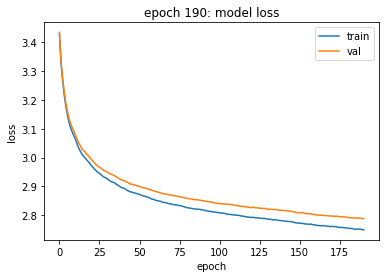

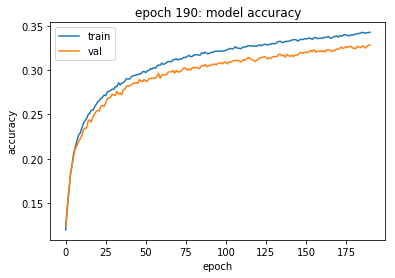



Epoch 191/600 ...........
Loss train: 2.7501398386210516 
Loss val: 2.7874299227450594 
Train accuracy :  0.341875 
Validation accuracy :  0.3272
Alpha:  0.5


Epoch 192/600 ...........
Loss train: 2.748710038694503 
Loss val: 2.7870430814628957 
Train accuracy :  0.34385 
Validation accuracy :  0.3287
Alpha:  0.5


Epoch 193/600 ...........
Loss train: 2.747660217959557 
Loss val: 2.7855818006673054 
Train accuracy :  0.343625 
Validation accuracy :  0.3298
Alpha:  0.5


Epoch 194/600 ...........
Loss train: 2.747349733737765 
Loss val: 2.784812052813305 
Train accuracy :  0.343125 
Validation accuracy :  0.329
Alpha:  0.5


Epoch 195/600 ...........
Loss train: 2.747162002477771 
Loss val: 2.785512399888478 
Train accuracy :  0.343725 
Validation accuracy :  0.3281
Alpha:  0.5


Epoch 196/600 ...........
Loss train: 2.7467777233953026 
Loss val: 2.785294274916564 
Train accuracy :  0.3439 
Validation accuracy :  0.3281
Alpha:  0.5


Epoch 197/600 ...........
Loss train: 2.746529681

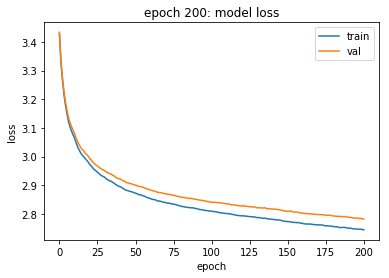

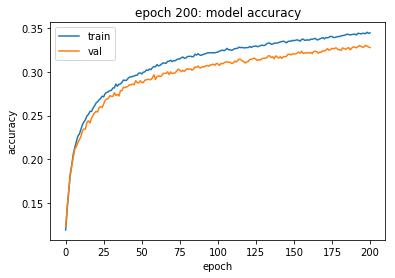



Epoch 201/600 ...........
Loss train: 2.7436332080331107 
Loss val: 2.781802552741332 
Train accuracy :  0.343975 
Validation accuracy :  0.3301
Alpha:  0.5


Epoch 202/600 ...........
Loss train: 2.7436114801180773 
Loss val: 2.78143011475685 
Train accuracy :  0.344025 
Validation accuracy :  0.3279
Alpha:  0.5


Epoch 203/600 ...........
Loss train: 2.742410549897272 
Loss val: 2.779740596983795 
Train accuracy :  0.345375 
Validation accuracy :  0.3307
Alpha:  0.5


Epoch 204/600 ...........
Loss train: 2.7417953709109355 
Loss val: 2.780594803883216 
Train accuracy :  0.345025 
Validation accuracy :  0.3292
Alpha:  0.5


Epoch 205/600 ...........
Loss train: 2.7407840682784252 
Loss val: 2.7795194063053925 
Train accuracy :  0.345175 
Validation accuracy :  0.3298
Alpha:  0.5


Epoch 206/600 ...........
Loss train: 2.740019944346143 
Loss val: 2.7802752711610648 
Train accuracy :  0.3465 
Validation accuracy :  0.3285
Alpha:  0.5


Epoch 207/600 ...........
Loss train: 2.7399960

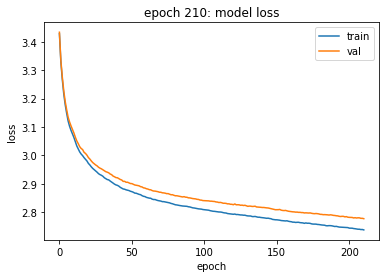

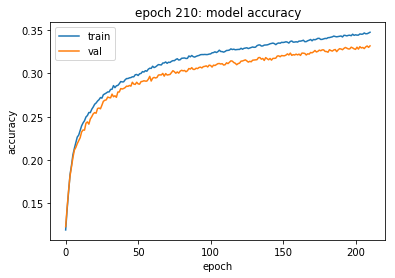



Epoch 211/600 ...........
Loss train: 2.7375477644693222 
Loss val: 2.776693812302492 
Train accuracy :  0.345525 
Validation accuracy :  0.3302
Alpha:  0.5


Epoch 212/600 ...........
Loss train: 2.736908961103544 
Loss val: 2.7769141636531067 
Train accuracy :  0.3471 
Validation accuracy :  0.3313
Alpha:  0.5


Epoch 213/600 ...........
Loss train: 2.7362289315868127 
Loss val: 2.775775773712696 
Train accuracy :  0.346375 
Validation accuracy :  0.3307
Alpha:  0.5


Epoch 214/600 ...........
Loss train: 2.7358724488988644 
Loss val: 2.775502134002936 
Train accuracy :  0.34685 
Validation accuracy :  0.3299
Alpha:  0.5


Epoch 215/600 ...........
Loss train: 2.7361716362337356 
Loss val: 2.77632812509445 
Train accuracy :  0.346675 
Validation accuracy :  0.3295
Alpha:  0.5


Epoch 216/600 ...........
Loss train: 2.7362874786624323 
Loss val: 2.7753950735670316 
Train accuracy :  0.346875 
Validation accuracy :  0.3301
Alpha:  0.5


Epoch 217/600 ...........
Loss train: 2.7350200

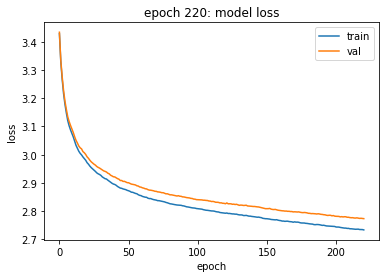

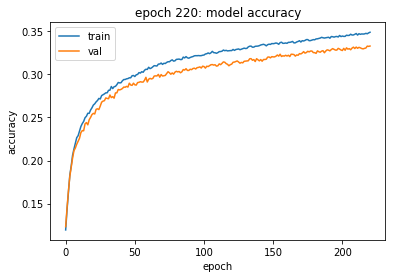



Epoch 221/600 ...........
Loss train: 2.731951075631225 
Loss val: 2.771953274789849 
Train accuracy :  0.347875 
Validation accuracy :  0.3307
Alpha:  0.5


Epoch 222/600 ...........
Loss train: 2.7311768802142926 
Loss val: 2.7717660936640844 
Train accuracy :  0.349 
Validation accuracy :  0.3329
Alpha:  0.5


Epoch 223/600 ...........
Loss train: 2.731317032032259 
Loss val: 2.7717561274029987 
Train accuracy :  0.34815 
Validation accuracy :  0.3308
Alpha:  0.5


Epoch 224/600 ...........
Loss train: 2.730899851434133 
Loss val: 2.771073431944617 
Train accuracy :  0.34855 
Validation accuracy :  0.3312
Alpha:  0.5


Epoch 225/600 ...........
Loss train: 2.7302073727256095 
Loss val: 2.77050261503203 
Train accuracy :  0.34905 
Validation accuracy :  0.3315
Alpha:  0.5


Epoch 226/600 ...........
Loss train: 2.7307537975552223 
Loss val: 2.7709583790153802 
Train accuracy :  0.349875 
Validation accuracy :  0.3322
Alpha:  0.5


Epoch 227/600 ...........
Loss train: 2.73051464784

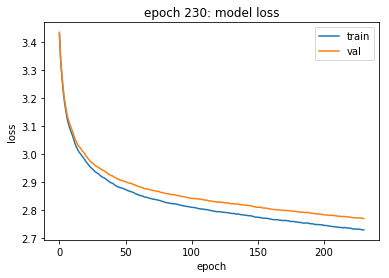

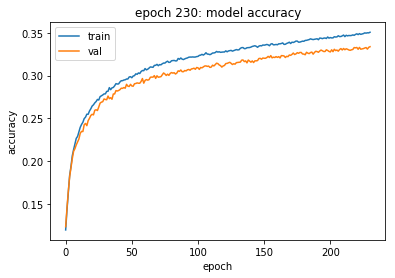



Epoch 231/600 ...........
Loss train: 2.7266088125246877 
Loss val: 2.7681711372301345 
Train accuracy :  0.350475 
Validation accuracy :  0.3346
Alpha:  0.5


Epoch 232/600 ...........
Loss train: 2.7267049124720653 
Loss val: 2.7684263875376067 
Train accuracy :  0.350675 
Validation accuracy :  0.3338
Alpha:  0.5


Epoch 233/600 ...........
Loss train: 2.7258928029926546 
Loss val: 2.7680715235585116 
Train accuracy :  0.35025 
Validation accuracy :  0.3337
Alpha:  0.5


Epoch 234/600 ...........
Loss train: 2.7255338852258317 
Loss val: 2.767684067524489 
Train accuracy :  0.3511 
Validation accuracy :  0.3322
Alpha:  0.5


Epoch 235/600 ...........
Loss train: 2.7248836170582322 
Loss val: 2.7678802648011547 
Train accuracy :  0.35025 
Validation accuracy :  0.3321
Alpha:  0.5


Epoch 236/600 ...........
Loss train: 2.724720498634223 
Loss val: 2.766482885902511 
Train accuracy :  0.350925 
Validation accuracy :  0.3352
Alpha:  0.5


Epoch 237/600 ...........
Loss train: 2.72455

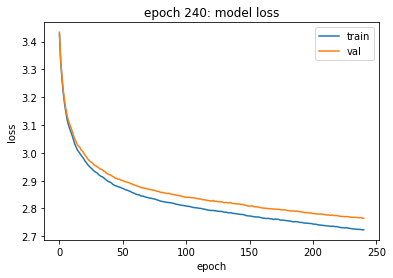

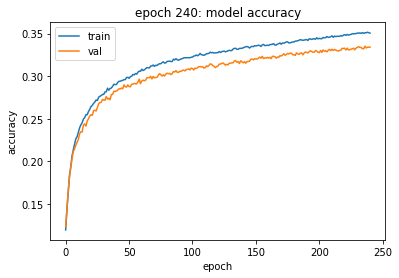



Epoch 241/600 ...........
Loss train: 2.7223749141948925 
Loss val: 2.7654714278017942 
Train accuracy :  0.3505 
Validation accuracy :  0.3333
Alpha:  0.5


Epoch 242/600 ...........
Loss train: 2.722160569056177 
Loss val: 2.765146107535767 
Train accuracy :  0.3517 
Validation accuracy :  0.3332
Alpha:  0.5


Epoch 243/600 ...........
Loss train: 2.72197263762977 
Loss val: 2.764447310358237 
Train accuracy :  0.351525 
Validation accuracy :  0.3359
Alpha:  0.5


Epoch 244/600 ...........
Loss train: 2.72202351291278 
Loss val: 2.765160784282492 
Train accuracy :  0.351275 
Validation accuracy :  0.3341
Alpha:  0.5


Epoch 245/600 ...........
Loss train: 2.7222356359925164 
Loss val: 2.765700657075741 
Train accuracy :  0.351675 
Validation accuracy :  0.3336
Alpha:  0.5


Epoch 246/600 ...........
Loss train: 2.7217760603940255 
Loss val: 2.7647179530438604 
Train accuracy :  0.3514 
Validation accuracy :  0.3337
Alpha:  0.5


Epoch 247/600 ...........
Loss train: 2.7217531914813

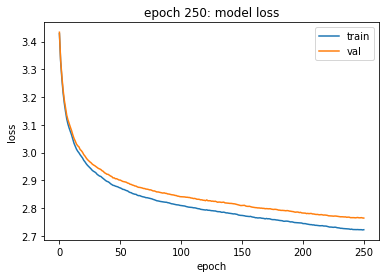

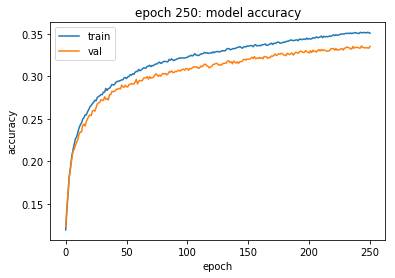



Epoch 251/600 ...........
Loss train: 2.720342472968707 
Loss val: 2.76374285966306 
Train accuracy :  0.352625 
Validation accuracy :  0.3336
Alpha:  0.5


Epoch 252/600 ...........
Loss train: 2.7202192384028354 
Loss val: 2.7639628969306758 
Train accuracy :  0.352675 
Validation accuracy :  0.3338
Alpha:  0.5


Epoch 253/600 ...........
Loss train: 2.7201287793590048 
Loss val: 2.762372313916877 
Train accuracy :  0.352825 
Validation accuracy :  0.3358
Alpha:  0.5


Epoch 254/600 ...........
Loss train: 2.7201474765021145 
Loss val: 2.763101426371782 
Train accuracy :  0.35265 
Validation accuracy :  0.3346
Alpha:  0.5


Epoch 255/600 ...........
Loss train: 2.7188180523157834 
Loss val: 2.7612257184113167 
Train accuracy :  0.353325 
Validation accuracy :  0.3348
Alpha:  0.5


Epoch 256/600 ...........
Loss train: 2.7189205035065673 
Loss val: 2.7611172163870354 
Train accuracy :  0.353725 
Validation accuracy :  0.3361
Alpha:  0.5


Epoch 257/600 ...........
Loss train: 2.7192

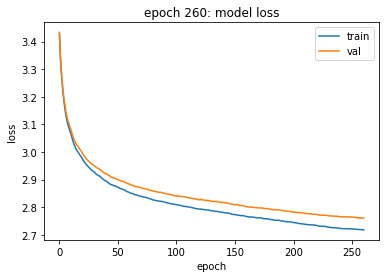

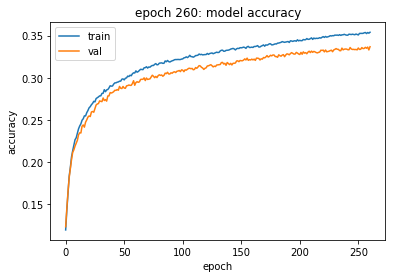



Epoch 261/600 ...........
Loss train: 2.7173763102612956 
Loss val: 2.759213646781618 
Train accuracy :  0.353975 
Validation accuracy :  0.3368
Alpha:  0.5


Epoch 262/600 ...........
Loss train: 2.7165291957275763 
Loss val: 2.7584520501023264 
Train accuracy :  0.35425 
Validation accuracy :  0.3378
Alpha:  0.5


Epoch 263/600 ...........
Loss train: 2.7167602709190213 
Loss val: 2.758313811101948 
Train accuracy :  0.354275 
Validation accuracy :  0.3374
Alpha:  0.5


Epoch 264/600 ...........
Loss train: 2.714965210537455 
Loss val: 2.75647166461962 
Train accuracy :  0.355075 
Validation accuracy :  0.3371
Alpha:  0.5


Epoch 265/600 ...........
Loss train: 2.7143079014456744 
Loss val: 2.7565419074582262 
Train accuracy :  0.3556 
Validation accuracy :  0.3375
Alpha:  0.5


Epoch 266/600 ...........
Loss train: 2.71408565063528 
Loss val: 2.755283517121314 
Train accuracy :  0.354625 
Validation accuracy :  0.3383
Alpha:  0.5


Epoch 267/600 ...........
Loss train: 2.713204564

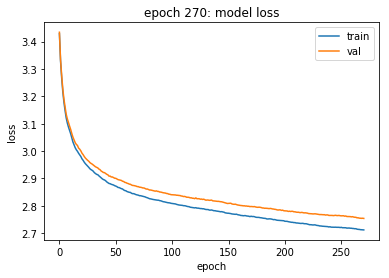

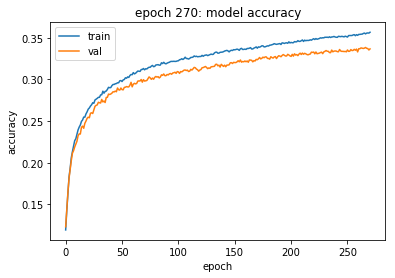



Epoch 271/600 ...........
Loss train: 2.710886857535634 
Loss val: 2.7529561956566804 
Train accuracy :  0.356225 
Validation accuracy :  0.3359
Alpha:  0.5


Epoch 272/600 ...........
Loss train: 2.710890296938425 
Loss val: 2.75318296615005 
Train accuracy :  0.355425 
Validation accuracy :  0.3384
Alpha:  0.5


Epoch 273/600 ...........
Loss train: 2.710809185112089 
Loss val: 2.7524530813842314 
Train accuracy :  0.35585 
Validation accuracy :  0.3354
Alpha:  0.5


Epoch 274/600 ...........
Loss train: 2.710405463309449 
Loss val: 2.752662310959443 
Train accuracy :  0.356825 
Validation accuracy :  0.3381
Alpha:  0.5


Epoch 275/600 ...........
Loss train: 2.7097936737215793 
Loss val: 2.751671296914256 
Train accuracy :  0.357125 
Validation accuracy :  0.3389
Alpha:  0.5


Epoch 276/600 ...........
Loss train: 2.708823852894282 
Loss val: 2.7514844964042675 
Train accuracy :  0.357 
Validation accuracy :  0.3388
Alpha:  0.5


Epoch 277/600 ...........
Loss train: 2.70846031758

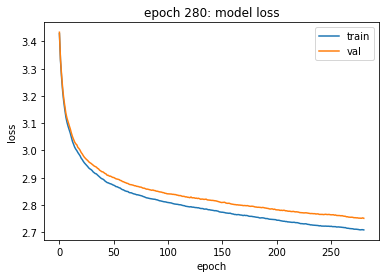

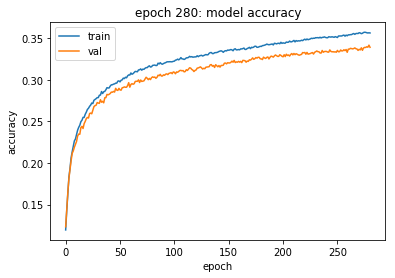



Epoch 281/600 ...........
Loss train: 2.7085689597863567 
Loss val: 2.7515582896093047 
Train accuracy :  0.355325 
Validation accuracy :  0.3362
Alpha:  0.5


Epoch 282/600 ...........
Loss train: 2.7081582915264844 
Loss val: 2.7510167010357436 
Train accuracy :  0.35635 
Validation accuracy :  0.3383
Alpha:  0.5


Epoch 283/600 ...........
Loss train: 2.7071717054336584 
Loss val: 2.751274987596869 
Train accuracy :  0.356575 
Validation accuracy :  0.3391
Alpha:  0.5


Epoch 284/600 ...........
Loss train: 2.7071355626763576 
Loss val: 2.7494826596442272 
Train accuracy :  0.356575 
Validation accuracy :  0.3391
Alpha:  0.5


Epoch 285/600 ...........
Loss train: 2.7070541127887697 
Loss val: 2.7491407826511653 
Train accuracy :  0.356475 
Validation accuracy :  0.3382
Alpha:  0.5


Epoch 286/600 ...........
Loss train: 2.7061180746324607 
Loss val: 2.7489110541554584 
Train accuracy :  0.3565 
Validation accuracy :  0.341
Alpha:  0.5


Epoch 287/600 ...........
Loss train: 2.705

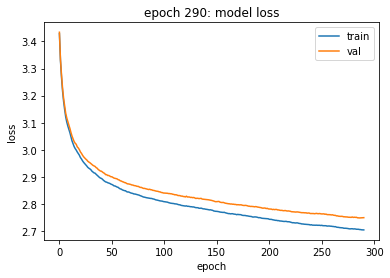

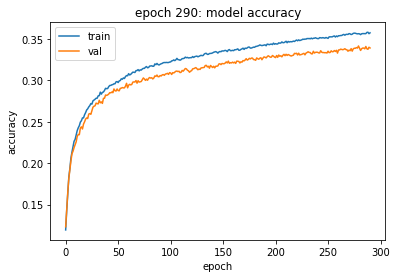



Epoch 291/600 ...........
Loss train: 2.704362931143899 
Loss val: 2.74902879992019 
Train accuracy :  0.35735 
Validation accuracy :  0.3401
Alpha:  0.5


Epoch 292/600 ...........
Loss train: 2.704076613916925 
Loss val: 2.747892309730435 
Train accuracy :  0.3557 
Validation accuracy :  0.3412
Alpha:  0.5


Epoch 293/600 ...........
Loss train: 2.7029573019979733 
Loss val: 2.7468625941436735 
Train accuracy :  0.357125 
Validation accuracy :  0.3418
Alpha:  0.5


Epoch 294/600 ...........
Loss train: 2.702789435297131 
Loss val: 2.74626381430247 
Train accuracy :  0.358 
Validation accuracy :  0.3421
Alpha:  0.5


Epoch 295/600 ...........
Loss train: 2.7018890025763094 
Loss val: 2.746052725884268 
Train accuracy :  0.3575 
Validation accuracy :  0.3418
Alpha:  0.5


Epoch 296/600 ...........
Loss train: 2.7014763464327265 
Loss val: 2.745886767320392 
Train accuracy :  0.35705 
Validation accuracy :  0.3418
Alpha:  0.5


Epoch 297/600 ...........
Loss train: 2.7013561698919792 

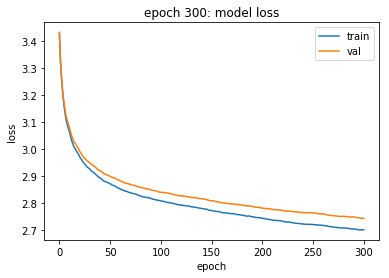

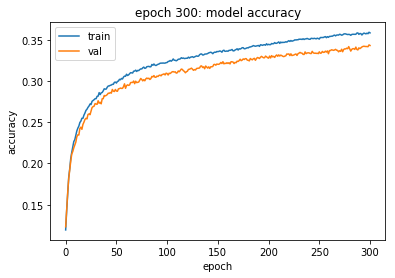



Epoch 301/600 ...........
Loss train: 2.7008208873882564 
Loss val: 2.7432775918504957 
Train accuracy :  0.35845 
Validation accuracy :  0.3434
Alpha:  0.5


Epoch 302/600 ...........
Loss train: 2.6999807925072257 
Loss val: 2.743799573937951 
Train accuracy :  0.35925 
Validation accuracy :  0.3434
Alpha:  0.5


Epoch 303/600 ...........
Loss train: 2.70005072652253 
Loss val: 2.743205322671143 
Train accuracy :  0.358925 
Validation accuracy :  0.344
Alpha:  0.5


Epoch 304/600 ...........
Loss train: 2.699146658112299 
Loss val: 2.7421468021460447 
Train accuracy :  0.35905 
Validation accuracy :  0.3429
Alpha:  0.5


Epoch 305/600 ...........
Loss train: 2.6989876065618628 
Loss val: 2.7416324272830312 
Train accuracy :  0.360075 
Validation accuracy :  0.3425
Alpha:  0.5


Epoch 306/600 ...........
Loss train: 2.6984670017811925 
Loss val: 2.741942837110295 
Train accuracy :  0.35995 
Validation accuracy :  0.3424
Alpha:  0.5


Epoch 307/600 ...........
Loss train: 2.697398635

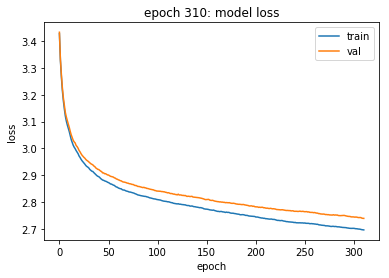

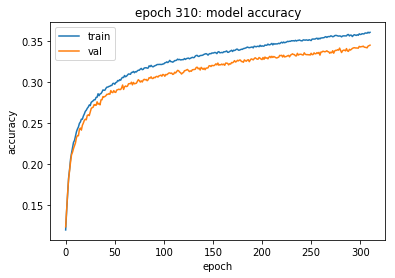



Epoch 311/600 ...........
Loss train: 2.6953502068025905 
Loss val: 2.7381926919211548 
Train accuracy :  0.361175 
Validation accuracy :  0.3444
Alpha:  0.5


Epoch 312/600 ...........
Loss train: 2.6950575137637323 
Loss val: 2.7379993474333957 
Train accuracy :  0.3612 
Validation accuracy :  0.3457
Alpha:  0.5


Epoch 313/600 ...........
Loss train: 2.6950417558933513 
Loss val: 2.7378446328211843 
Train accuracy :  0.361625 
Validation accuracy :  0.344
Alpha:  0.5


Epoch 314/600 ...........
Loss train: 2.694547719435445 
Loss val: 2.7387288947116 
Train accuracy :  0.361225 
Validation accuracy :  0.344
Alpha:  0.5


Epoch 315/600 ...........
Loss train: 2.6936657362994403 
Loss val: 2.738410619003428 
Train accuracy :  0.361275 
Validation accuracy :  0.3466
Alpha:  0.5


Epoch 316/600 ...........
Loss train: 2.693277998470877 
Loss val: 2.7367906512471087 
Train accuracy :  0.362 
Validation accuracy :  0.3465
Alpha:  0.5


Epoch 317/600 ...........
Loss train: 2.69353351117

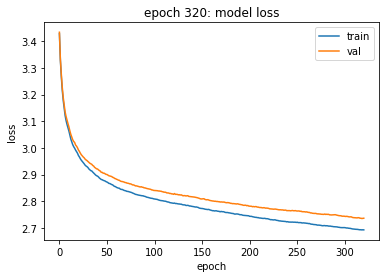

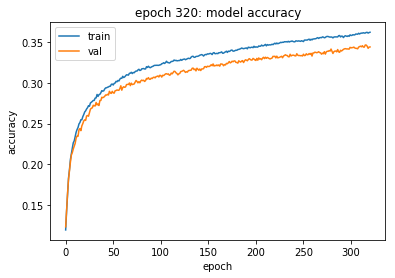



Epoch 321/600 ...........
Loss train: 2.6924240570780555 
Loss val: 2.7362456618748565 
Train accuracy :  0.362175 
Validation accuracy :  0.3456
Alpha:  0.5


Epoch 322/600 ...........
Loss train: 2.6919662213121875 
Loss val: 2.736015057962032 
Train accuracy :  0.363075 
Validation accuracy :  0.3464
Alpha:  0.5


Epoch 323/600 ...........
Loss train: 2.691069022179595 
Loss val: 2.7364339064780814 
Train accuracy :  0.3628 
Validation accuracy :  0.3443
Alpha:  0.5


Epoch 324/600 ...........
Loss train: 2.690605645330951 
Loss val: 2.734031750501786 
Train accuracy :  0.36165 
Validation accuracy :  0.344
Alpha:  0.5


Epoch 325/600 ...........
Loss train: 2.6896451003284194 
Loss val: 2.7334610319020385 
Train accuracy :  0.3622 
Validation accuracy :  0.3467
Alpha:  0.5


Epoch 326/600 ...........
Loss train: 2.6895171748514834 
Loss val: 2.7333665410559234 
Train accuracy :  0.36225 
Validation accuracy :  0.3457
Alpha:  0.5


Epoch 327/600 ...........
Loss train: 2.689766149

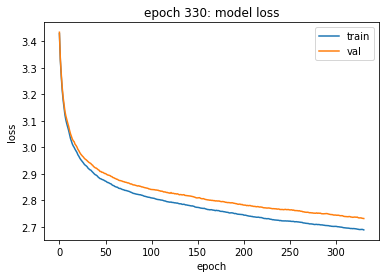

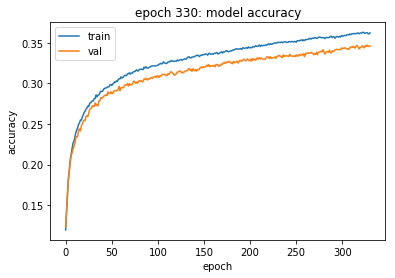



Epoch 331/600 ...........
Loss train: 2.688406233475357 
Loss val: 2.730816850706593 
Train accuracy :  0.362025 
Validation accuracy :  0.3468
Alpha:  0.5


Epoch 332/600 ...........
Loss train: 2.688300232266468 
Loss val: 2.730387548535699 
Train accuracy :  0.363225 
Validation accuracy :  0.3459
Alpha:  0.5


Epoch 333/600 ...........
Loss train: 2.687211088357126 
Loss val: 2.7297586862668797 
Train accuracy :  0.362375 
Validation accuracy :  0.3471
Alpha:  0.5


Epoch 334/600 ...........
Loss train: 2.6874850086660613 
Loss val: 2.729616922638134 
Train accuracy :  0.36245 
Validation accuracy :  0.3458
Alpha:  0.5


Epoch 335/600 ...........
Loss train: 2.6863469968057783 
Loss val: 2.728232762386807 
Train accuracy :  0.362925 
Validation accuracy :  0.3439
Alpha:  0.5


Epoch 336/600 ...........
Loss train: 2.685883451723608 
Loss val: 2.7295051256079867 
Train accuracy :  0.363875 
Validation accuracy :  0.3454
Alpha:  0.5


Epoch 337/600 ...........
Loss train: 2.6860316

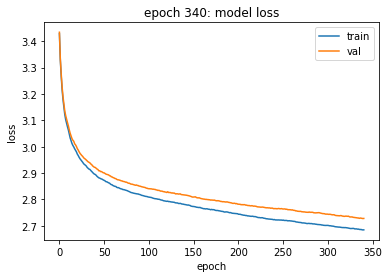

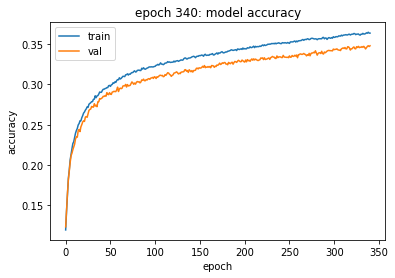



Epoch 341/600 ...........
Loss train: 2.684072957990136 
Loss val: 2.7281328453519875 
Train accuracy :  0.363 
Validation accuracy :  0.3448
Alpha:  0.5


Epoch 342/600 ...........
Loss train: 2.683428464164178 
Loss val: 2.727809780157998 
Train accuracy :  0.363325 
Validation accuracy :  0.3465
Alpha:  0.5


Epoch 343/600 ...........
Loss train: 2.6830130953875098 
Loss val: 2.7260394300060042 
Train accuracy :  0.3632 
Validation accuracy :  0.3464
Alpha:  0.5


Epoch 344/600 ...........
Loss train: 2.682864126619322 
Loss val: 2.726451209858557 
Train accuracy :  0.36315 
Validation accuracy :  0.3476
Alpha:  0.5


Epoch 345/600 ...........
Loss train: 2.6831796256604883 
Loss val: 2.726146389428734 
Train accuracy :  0.3632 
Validation accuracy :  0.3463
Alpha:  0.5


Epoch 346/600 ...........
Loss train: 2.6829497882372206 
Loss val: 2.7262504374741257 
Train accuracy :  0.3634 
Validation accuracy :  0.3455
Alpha:  0.5


Epoch 347/600 ...........
Loss train: 2.68284310011585

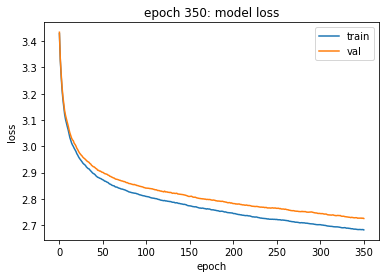

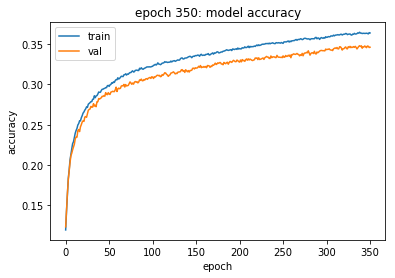



Epoch 351/600 ...........
Loss train: 2.6808254394172355 
Loss val: 2.7257571364497997 
Train accuracy :  0.3645 
Validation accuracy :  0.3494
Alpha:  0.5


Epoch 352/600 ...........
Loss train: 2.6807481000197466 
Loss val: 2.7259168173180286 
Train accuracy :  0.36355 
Validation accuracy :  0.349
Alpha:  0.5


Epoch 353/600 ...........
Loss train: 2.680572527617038 
Loss val: 2.724592759885142 
Train accuracy :  0.364425 
Validation accuracy :  0.349
Alpha:  0.5


Epoch 354/600 ...........
Loss train: 2.6806599900674977 
Loss val: 2.723326079077256 
Train accuracy :  0.363925 
Validation accuracy :  0.3484
Alpha:  0.5


Epoch 355/600 ...........
Loss train: 2.6792952640773486 
Loss val: 2.72291684367037 
Train accuracy :  0.36395 
Validation accuracy :  0.3489
Alpha:  0.5


Epoch 356/600 ...........
Loss train: 2.6792683711933307 
Loss val: 2.7227177604596067 
Train accuracy :  0.3646 
Validation accuracy :  0.3466
Alpha:  0.5


Epoch 357/600 ...........
Loss train: 2.67885796575

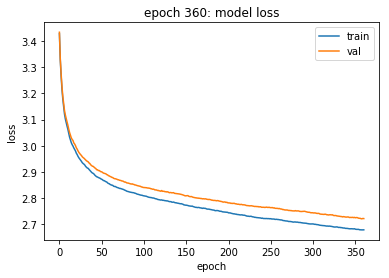

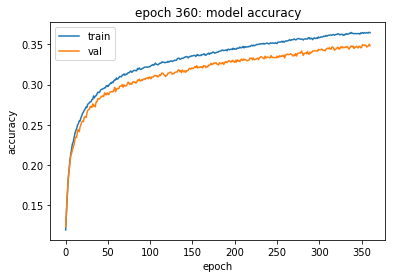



Epoch 361/600 ...........
Loss train: 2.6789148038791017 
Loss val: 2.7210196125053256 
Train accuracy :  0.3637 
Validation accuracy :  0.3495
Alpha:  0.5


Epoch 362/600 ...........
Loss train: 2.678588878286793 
Loss val: 2.7203052665276335 
Train accuracy :  0.364175 
Validation accuracy :  0.3503
Alpha:  0.5


Epoch 363/600 ...........
Loss train: 2.6784180926492716 
Loss val: 2.720530716809609 
Train accuracy :  0.363575 
Validation accuracy :  0.3511
Alpha:  0.5


Epoch 364/600 ...........
Loss train: 2.6783328958655654 
Loss val: 2.7211933951208933 
Train accuracy :  0.36445 
Validation accuracy :  0.3493
Alpha:  0.5


Epoch 365/600 ...........
Loss train: 2.6769932068152222 
Loss val: 2.719635155115989 
Train accuracy :  0.36415 
Validation accuracy :  0.3502
Alpha:  0.5


Epoch 366/600 ...........
Loss train: 2.6777223441490463 
Loss val: 2.719798086335082 
Train accuracy :  0.3637 
Validation accuracy :  0.3493
Alpha:  0.5


Epoch 367/600 ...........
Loss train: 2.67718675

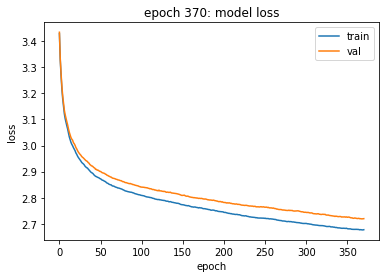

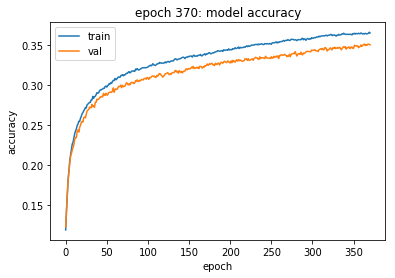



Epoch 371/600 ...........
Loss train: 2.677087926716244 
Loss val: 2.7191553343128496 
Train accuracy :  0.365275 
Validation accuracy :  0.3491
Alpha:  0.5


Epoch 372/600 ...........
Loss train: 2.6751148357769385 
Loss val: 2.718914771689855 
Train accuracy :  0.366525 
Validation accuracy :  0.3498
Alpha:  0.5


Epoch 373/600 ...........
Loss train: 2.6750038330759973 
Loss val: 2.718473866760065 
Train accuracy :  0.366075 
Validation accuracy :  0.3497
Alpha:  0.5


Epoch 374/600 ...........
Loss train: 2.6748134028713464 
Loss val: 2.719134322724356 
Train accuracy :  0.365925 
Validation accuracy :  0.3498
Alpha:  0.5


Epoch 375/600 ...........
Loss train: 2.674355532615824 
Loss val: 2.7192349321354627 
Train accuracy :  0.3654 
Validation accuracy :  0.3519
Alpha:  0.5


Epoch 376/600 ...........
Loss train: 2.6727305947882454 
Loss val: 2.717670129536006 
Train accuracy :  0.36555 
Validation accuracy :  0.35
Alpha:  0.5


Epoch 377/600 ...........
Loss train: 2.672786451

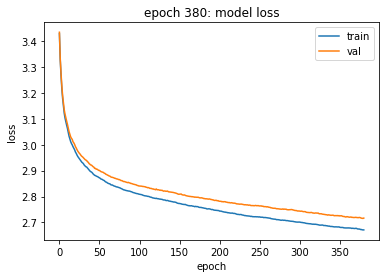

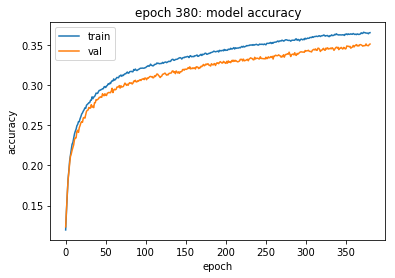



Epoch 381/600 ...........
Loss train: 2.6712766906940333 
Loss val: 2.7156865099928265 
Train accuracy :  0.367275 
Validation accuracy :  0.3504
Alpha:  0.5


Epoch 382/600 ...........
Loss train: 2.6713880106770755 
Loss val: 2.715533633401624 
Train accuracy :  0.367925 
Validation accuracy :  0.3525
Alpha:  0.5


Epoch 383/600 ...........
Loss train: 2.671050767407697 
Loss val: 2.714423110615867 
Train accuracy :  0.367 
Validation accuracy :  0.3539
Alpha:  0.5


Epoch 384/600 ...........
Loss train: 2.670254389436756 
Loss val: 2.714470275163366 
Train accuracy :  0.366 
Validation accuracy :  0.3531
Alpha:  0.5


Epoch 385/600 ...........
Loss train: 2.670560006094994 
Loss val: 2.7134093678184343 
Train accuracy :  0.36585 
Validation accuracy :  0.3513
Alpha:  0.5


Epoch 386/600 ...........
Loss train: 2.670218950184191 
Loss val: 2.714989773474762 
Train accuracy :  0.366075 
Validation accuracy :  0.3529
Alpha:  0.5


Epoch 387/600 ...........
Loss train: 2.6696726688463

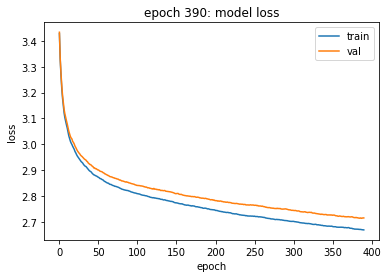

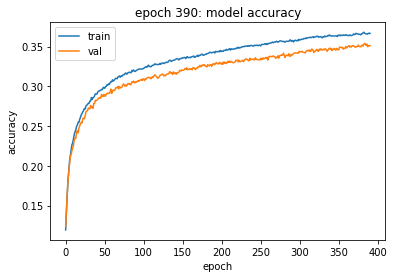



Epoch 391/600 ...........
Loss train: 2.667731798988503 
Loss val: 2.714895606290405 
Train accuracy :  0.365975 
Validation accuracy :  0.3496
Alpha:  0.5


Epoch 392/600 ...........
Loss train: 2.667010735469767 
Loss val: 2.714529647849945 
Train accuracy :  0.366875 
Validation accuracy :  0.3512
Alpha:  0.5


Epoch 393/600 ...........
Loss train: 2.666448283133879 
Loss val: 2.714240632624798 
Train accuracy :  0.367825 
Validation accuracy :  0.3523
Alpha:  0.5


Epoch 394/600 ...........
Loss train: 2.6659499209286692 
Loss val: 2.7127852105318144 
Train accuracy :  0.3665 
Validation accuracy :  0.3536
Alpha:  0.5


Epoch 395/600 ...........
Loss train: 2.6658462623101555 
Loss val: 2.712936664423547 
Train accuracy :  0.367325 
Validation accuracy :  0.3528
Alpha:  0.5


Epoch 396/600 ...........
Loss train: 2.6660376051453603 
Loss val: 2.713119266447024 
Train accuracy :  0.36745 
Validation accuracy :  0.3536
Alpha:  0.5


Epoch 397/600 ...........
Loss train: 2.666075359

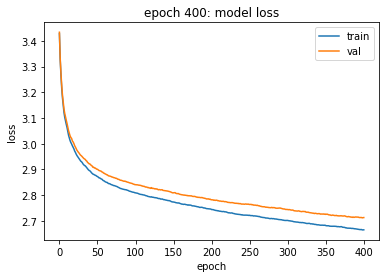

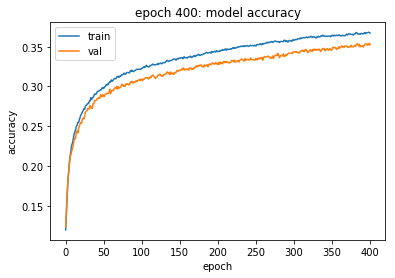



Epoch 401/600 ...........
Loss train: 2.6640286277975416 
Loss val: 2.7114221920988215 
Train accuracy :  0.368175 
Validation accuracy :  0.3526
Alpha:  0.5


Epoch 402/600 ...........
Loss train: 2.663411631520466 
Loss val: 2.710129362264017 
Train accuracy :  0.367475 
Validation accuracy :  0.3518
Alpha:  0.5


Epoch 403/600 ...........
Loss train: 2.662896751775649 
Loss val: 2.7108297502160776 
Train accuracy :  0.368625 
Validation accuracy :  0.3529
Alpha:  0.5


Epoch 404/600 ...........
Loss train: 2.6631759805745445 
Loss val: 2.709936000205486 
Train accuracy :  0.36825 
Validation accuracy :  0.3516
Alpha:  0.5


Epoch 405/600 ...........
Loss train: 2.6628247137824594 
Loss val: 2.710299957018499 
Train accuracy :  0.3687 
Validation accuracy :  0.353
Alpha:  0.5


Epoch 406/600 ...........
Loss train: 2.661792099429447 
Loss val: 2.70981064291108 
Train accuracy :  0.3682 
Validation accuracy :  0.3538
Alpha:  0.5


Epoch 407/600 ...........
Loss train: 2.661634857503

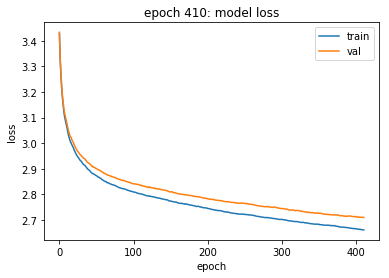

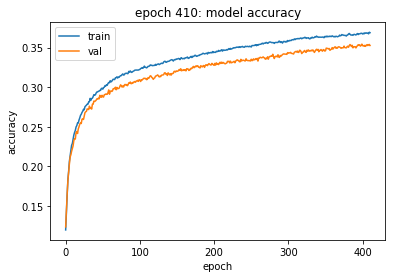



Epoch 411/600 ...........
Loss train: 2.6602695239021523 
Loss val: 2.708651254890659 
Train accuracy :  0.36845 
Validation accuracy :  0.3547
Alpha:  0.5


Epoch 412/600 ...........
Loss train: 2.659763168447012 
Loss val: 2.70898775533206 
Train accuracy :  0.368225 
Validation accuracy :  0.355
Alpha:  0.5


Epoch 413/600 ...........
Loss train: 2.659502182014101 
Loss val: 2.707613804845512 
Train accuracy :  0.368225 
Validation accuracy :  0.3558
Alpha:  0.5


Epoch 414/600 ...........
Loss train: 2.65992088400379 
Loss val: 2.7072996933948232 
Train accuracy :  0.368825 
Validation accuracy :  0.3564
Alpha:  0.5


Epoch 415/600 ...........
Loss train: 2.658780958727617 
Loss val: 2.707966574539441 
Train accuracy :  0.369975 
Validation accuracy :  0.3566
Alpha:  0.5


Epoch 416/600 ...........
Loss train: 2.658431574233015 
Loss val: 2.708137090295009 
Train accuracy :  0.369775 
Validation accuracy :  0.3545
Alpha:  0.5


Epoch 417/600 ...........
Loss train: 2.659238221290

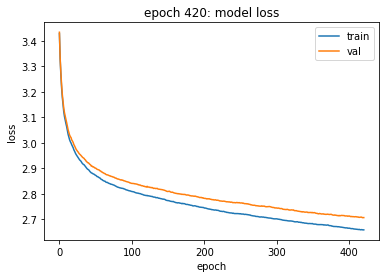

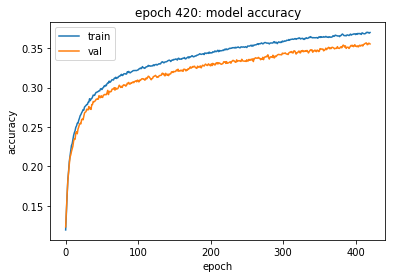



Epoch 421/600 ...........
Loss train: 2.6578522005884726 
Loss val: 2.7053859495572197 
Train accuracy :  0.368825 
Validation accuracy :  0.3571
Alpha:  0.5


Epoch 422/600 ...........
Loss train: 2.6565700613179972 
Loss val: 2.7053999393421653 
Train accuracy :  0.3702 
Validation accuracy :  0.3581
Alpha:  0.5


Epoch 423/600 ...........
Loss train: 2.6555626420816822 
Loss val: 2.704233564983921 
Train accuracy :  0.369875 
Validation accuracy :  0.3582
Alpha:  0.5


Epoch 424/600 ...........
Loss train: 2.6558310634477302 
Loss val: 2.7054572104618204 
Train accuracy :  0.370825 
Validation accuracy :  0.3561
Alpha:  0.5


Epoch 425/600 ...........
Loss train: 2.65639183991752 
Loss val: 2.7047471435752026 
Train accuracy :  0.37125 
Validation accuracy :  0.3577
Alpha:  0.5


Epoch 426/600 ...........
Loss train: 2.6556579855992344 
Loss val: 2.7043759979459274 
Train accuracy :  0.370925 
Validation accuracy :  0.3576
Alpha:  0.5


Epoch 427/600 ...........
Loss train: 2.6554

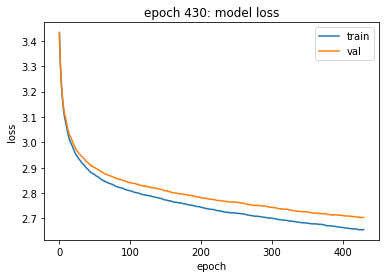

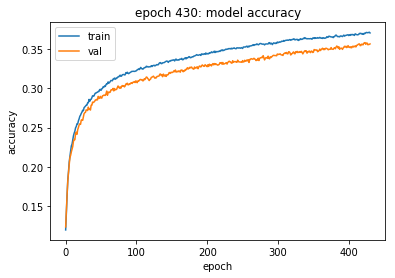



Epoch 431/600 ...........
Loss train: 2.6554799971735172 
Loss val: 2.7038542973049102 
Train accuracy :  0.37025 
Validation accuracy :  0.3552
Alpha:  0.5


Epoch 432/600 ...........
Loss train: 2.656074404643604 
Loss val: 2.704718823208146 
Train accuracy :  0.371575 
Validation accuracy :  0.3546
Alpha:  0.5


Epoch 433/600 ...........
Loss train: 2.6550477337706657 
Loss val: 2.704243038411886 
Train accuracy :  0.371375 
Validation accuracy :  0.3572
Alpha:  0.5


Epoch 434/600 ...........
Loss train: 2.6552485614525048 
Loss val: 2.7045756138985713 
Train accuracy :  0.3722 
Validation accuracy :  0.3556
Alpha:  0.5


Epoch 435/600 ...........
Loss train: 2.655014693740544 
Loss val: 2.704740367889109 
Train accuracy :  0.3715 
Validation accuracy :  0.3574
Alpha:  0.5


Epoch 436/600 ...........
Loss train: 2.6555886250087735 
Loss val: 2.7056799386244066 
Train accuracy :  0.37135 
Validation accuracy :  0.358
Alpha:  0.5


Epoch 437/600 ...........
Loss train: 2.6547927826

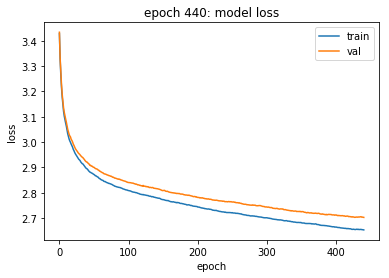

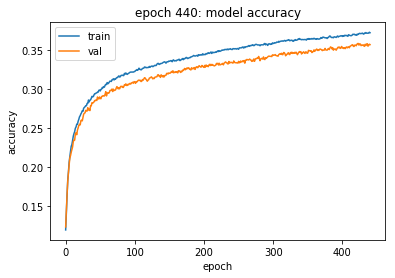



Epoch 441/600 ...........
Loss train: 2.6533221823096698 
Loss val: 2.7032211636904973 
Train accuracy :  0.371125 
Validation accuracy :  0.3586
Alpha:  0.5


Epoch 442/600 ...........
Loss train: 2.6536358131433775 
Loss val: 2.704038273346285 
Train accuracy :  0.37185 
Validation accuracy :  0.3601
Alpha:  0.5


Epoch 443/600 ...........
Loss train: 2.6529557227220257 
Loss val: 2.7023723056220477 
Train accuracy :  0.3724 
Validation accuracy :  0.3583
Alpha:  0.5


Epoch 444/600 ...........
Loss train: 2.653686496213719 
Loss val: 2.703627615072758 
Train accuracy :  0.372025 
Validation accuracy :  0.3571
Alpha:  0.5


Epoch 445/600 ...........
Loss train: 2.653166009029621 
Loss val: 2.7030149825700036 
Train accuracy :  0.373 
Validation accuracy :  0.3564
Alpha:  0.5


Epoch 446/600 ...........
Loss train: 2.652826874926956 
Loss val: 2.702026317531218 
Train accuracy :  0.37335 
Validation accuracy :  0.3581
Alpha:  0.5


Epoch 447/600 ...........
Loss train: 2.65190436182

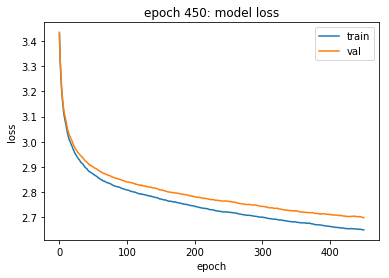

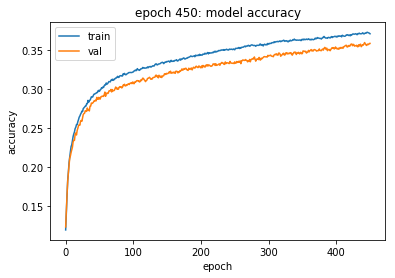



Epoch 451/600 ...........
Loss train: 2.6499650348811485 
Loss val: 2.6995707258115527 
Train accuracy :  0.37305 
Validation accuracy :  0.3593
Alpha:  0.5


Epoch 452/600 ...........
Loss train: 2.649366801589903 
Loss val: 2.6986836624775794 
Train accuracy :  0.372975 
Validation accuracy :  0.3588
Alpha:  0.5


Epoch 453/600 ...........
Loss train: 2.64899998144152 
Loss val: 2.699688817288629 
Train accuracy :  0.3741 
Validation accuracy :  0.3594
Alpha:  0.5


Epoch 454/600 ...........
Loss train: 2.648381169410172 
Loss val: 2.6982233377515077 
Train accuracy :  0.373075 
Validation accuracy :  0.3596
Alpha:  0.5


Epoch 455/600 ...........
Loss train: 2.6481617740614953 
Loss val: 2.698574299283622 
Train accuracy :  0.374025 
Validation accuracy :  0.3592
Alpha:  0.5


Epoch 456/600 ...........
Loss train: 2.6481593025154306 
Loss val: 2.6988909044961717 
Train accuracy :  0.373875 
Validation accuracy :  0.3599
Alpha:  0.5


Epoch 457/600 ...........
Loss train: 2.6478806

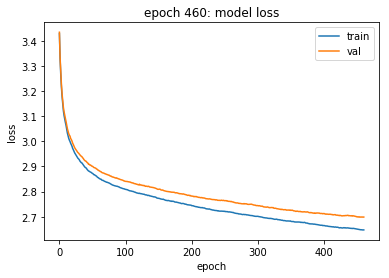

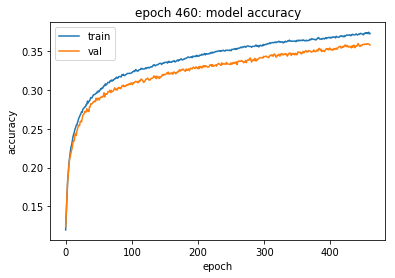



Epoch 461/600 ...........
Loss train: 2.6471529962506004 
Loss val: 2.698830224844296 
Train accuracy :  0.373075 
Validation accuracy :  0.3567
Alpha:  0.5


Epoch 462/600 ...........
Loss train: 2.64690238056446 
Loss val: 2.6979033815434783 
Train accuracy :  0.37355 
Validation accuracy :  0.3594
Alpha:  0.5


Epoch 463/600 ...........
Loss train: 2.646223759313352 
Loss val: 2.69682677031792 
Train accuracy :  0.373675 
Validation accuracy :  0.3582
Alpha:  0.5


Epoch 464/600 ...........
Loss train: 2.645880058236351 
Loss val: 2.6961842058964844 
Train accuracy :  0.3733 
Validation accuracy :  0.3613
Alpha:  0.5


Epoch 465/600 ...........
Loss train: 2.6455503542450707 
Loss val: 2.696062550700539 
Train accuracy :  0.37425 
Validation accuracy :  0.3598
Alpha:  0.5


Epoch 466/600 ...........
Loss train: 2.6453163067407894 
Loss val: 2.696681753723182 
Train accuracy :  0.374525 
Validation accuracy :  0.3601
Alpha:  0.5


Epoch 467/600 ...........
Loss train: 2.64534577422

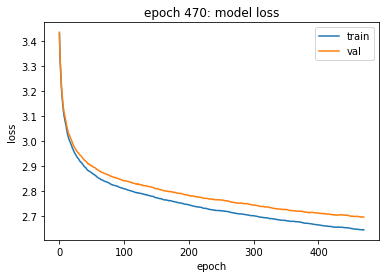

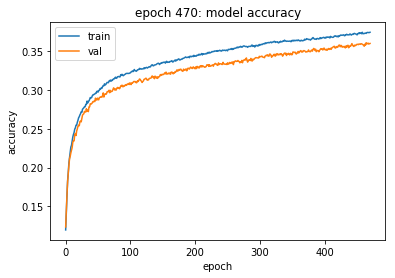



Epoch 471/600 ...........
Loss train: 2.6449178859373252 
Loss val: 2.6955738053648672 
Train accuracy :  0.374625 
Validation accuracy :  0.3612
Alpha:  0.5


Epoch 472/600 ...........
Loss train: 2.6444535635987627 
Loss val: 2.6949710869001406 
Train accuracy :  0.374375 
Validation accuracy :  0.3602
Alpha:  0.5


Epoch 473/600 ...........
Loss train: 2.6444127096657892 
Loss val: 2.6946106545191117 
Train accuracy :  0.374625 
Validation accuracy :  0.3605
Alpha:  0.5


Epoch 474/600 ...........
Loss train: 2.6445903210107042 
Loss val: 2.694562677214835 
Train accuracy :  0.374325 
Validation accuracy :  0.36
Alpha:  0.5


Epoch 475/600 ...........
Loss train: 2.6433240201605024 
Loss val: 2.6931545113510293 
Train accuracy :  0.37565 
Validation accuracy :  0.3604
Alpha:  0.5


Epoch 476/600 ...........
Loss train: 2.6438439355999206 
Loss val: 2.6928237790055913 
Train accuracy :  0.3754 
Validation accuracy :  0.3621
Alpha:  0.5


Epoch 477/600 ...........
Loss train: 2.6431

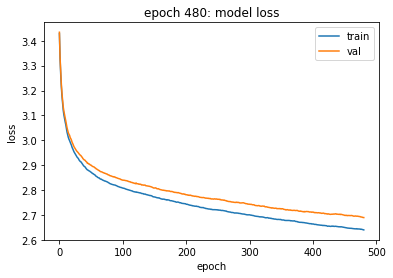

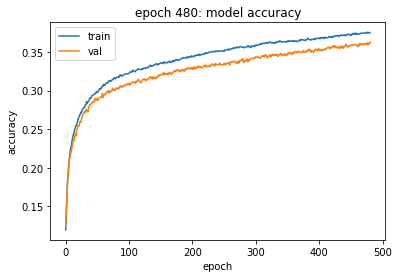



Epoch 481/600 ...........
Loss train: 2.64056617039842 
Loss val: 2.691397294998688 
Train accuracy :  0.375675 
Validation accuracy :  0.3609
Alpha:  0.5


Epoch 482/600 ...........
Loss train: 2.640450807780938 
Loss val: 2.690550442630116 
Train accuracy :  0.375175 
Validation accuracy :  0.3629
Alpha:  0.5


Epoch 483/600 ...........
Loss train: 2.6406179622642028 
Loss val: 2.690072055833971 
Train accuracy :  0.3755 
Validation accuracy :  0.3632
Alpha:  0.5


Epoch 484/600 ...........
Loss train: 2.640347276798672 
Loss val: 2.6902693303991696 
Train accuracy :  0.375275 
Validation accuracy :  0.3634
Alpha:  0.5


Epoch 485/600 ...........
Loss train: 2.6404260134707727 
Loss val: 2.689817708196949 
Train accuracy :  0.37585 
Validation accuracy :  0.3635
Alpha:  0.5


Epoch 486/600 ...........
Loss train: 2.6406923903652655 
Loss val: 2.6903737652320996 
Train accuracy :  0.3754 
Validation accuracy :  0.3628
Alpha:  0.5


Epoch 487/600 ...........
Loss train: 2.64024353653

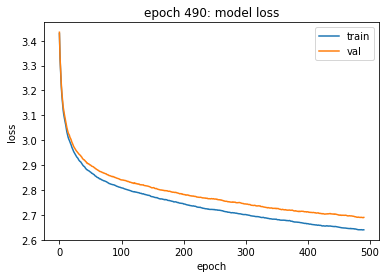

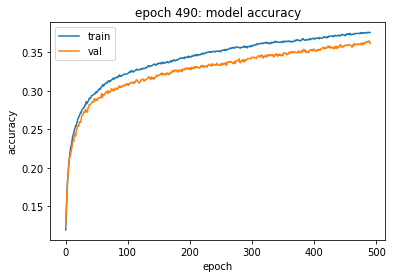



Epoch 491/600 ...........
Loss train: 2.639748876684697 
Loss val: 2.6904452546759865 
Train accuracy :  0.37515 
Validation accuracy :  0.3612
Alpha:  0.5


Epoch 492/600 ...........
Loss train: 2.6389611349209225 
Loss val: 2.6882421419043903 
Train accuracy :  0.3756 
Validation accuracy :  0.3621
Alpha:  0.5


Epoch 493/600 ...........
Loss train: 2.6383565766376638 
Loss val: 2.689328833670825 
Train accuracy :  0.375225 
Validation accuracy :  0.3611
Alpha:  0.5


Epoch 494/600 ...........
Loss train: 2.637247820403382 
Loss val: 2.687529667836177 
Train accuracy :  0.3761 
Validation accuracy :  0.3636
Alpha:  0.5


Epoch 495/600 ...........
Loss train: 2.6369832028087963 
Loss val: 2.686745951116997 
Train accuracy :  0.37655 
Validation accuracy :  0.364
Alpha:  0.5


Epoch 496/600 ...........
Loss train: 2.6370927875859955 
Loss val: 2.6860377294122935 
Train accuracy :  0.376275 
Validation accuracy :  0.3652
Alpha:  0.5


Epoch 497/600 ...........
Loss train: 2.6371674696

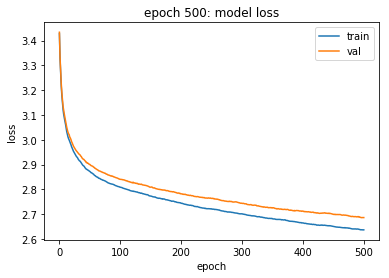

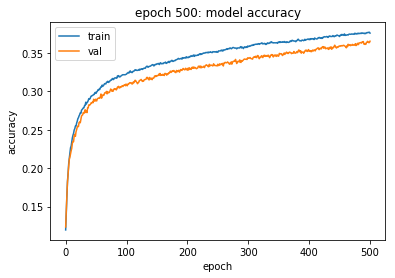



Epoch 501/600 ...........
Loss train: 2.6369375265838295 
Loss val: 2.68725820115802 
Train accuracy :  0.377175 
Validation accuracy :  0.3637
Alpha:  0.5


Epoch 502/600 ...........
Loss train: 2.637345734971732 
Loss val: 2.686793302129781 
Train accuracy :  0.37595 
Validation accuracy :  0.3646
Alpha:  0.5


Epoch 503/600 ...........
Loss train: 2.637001349267141 
Loss val: 2.686783290925491 
Train accuracy :  0.376375 
Validation accuracy :  0.3641
Alpha:  0.5


Epoch 504/600 ...........
Loss train: 2.636514171570187 
Loss val: 2.686603333409703 
Train accuracy :  0.37735 
Validation accuracy :  0.3648
Alpha:  0.5


Epoch 505/600 ...........
Loss train: 2.635953314748148 
Loss val: 2.6862596162747923 
Train accuracy :  0.376025 
Validation accuracy :  0.3649
Alpha:  0.5


Epoch 506/600 ...........
Loss train: 2.6364867894232544 
Loss val: 2.686707406513583 
Train accuracy :  0.37645 
Validation accuracy :  0.3651
Alpha:  0.5


Epoch 507/600 ...........
Loss train: 2.63607726382

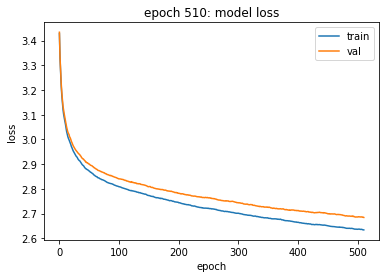

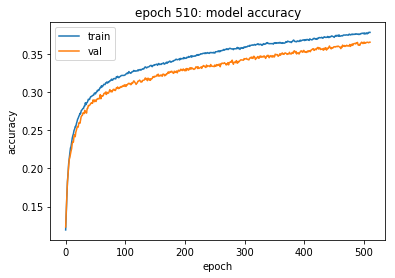



Epoch 511/600 ...........
Loss train: 2.6348602022883822 
Loss val: 2.6858928866255827 
Train accuracy :  0.377675 
Validation accuracy :  0.3627
Alpha:  0.5


Epoch 512/600 ...........
Loss train: 2.634225217161307 
Loss val: 2.6845870510852956 
Train accuracy :  0.3777 
Validation accuracy :  0.3647
Alpha:  0.5


Epoch 513/600 ...........
Loss train: 2.6345653158473183 
Loss val: 2.685843811877291 
Train accuracy :  0.37795 
Validation accuracy :  0.3634
Alpha:  0.5


Epoch 514/600 ...........
Loss train: 2.6350264900373266 
Loss val: 2.6858646450243726 
Train accuracy :  0.379425 
Validation accuracy :  0.3638
Alpha:  0.5


Epoch 515/600 ...........
Loss train: 2.6363024546585256 
Loss val: 2.6862741051180263 
Train accuracy :  0.37875 
Validation accuracy :  0.3649
Alpha:  0.5


Epoch 516/600 ...........
Loss train: 2.635051396774735 
Loss val: 2.685029462175163 
Train accuracy :  0.378825 
Validation accuracy :  0.3643
Alpha:  0.5


Epoch 517/600 ...........
Loss train: 2.633949

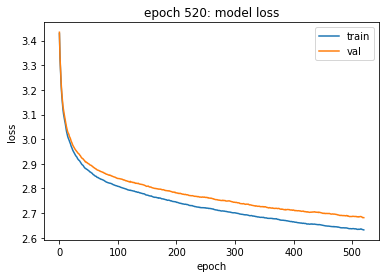

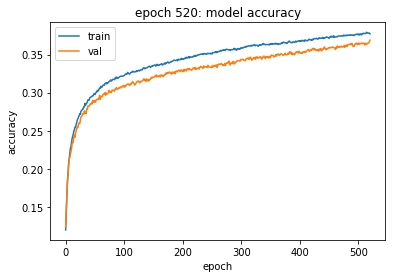



Epoch 521/600 ...........
Loss train: 2.6323490640467404 
Loss val: 2.6819432518710955 
Train accuracy :  0.37795 
Validation accuracy :  0.3679
Alpha:  0.5


Epoch 522/600 ...........
Loss train: 2.6315281123129832 
Loss val: 2.681429863486664 
Train accuracy :  0.3771 
Validation accuracy :  0.3672
Alpha:  0.5


Epoch 523/600 ...........
Loss train: 2.6313930694511654 
Loss val: 2.6824637983779054 
Train accuracy :  0.37795 
Validation accuracy :  0.3685
Alpha:  0.5


Epoch 524/600 ...........
Loss train: 2.6307305354549984 
Loss val: 2.6825941921724015 
Train accuracy :  0.378075 
Validation accuracy :  0.3679
Alpha:  0.5


Epoch 525/600 ...........
Loss train: 2.6304835869735856 
Loss val: 2.6816566608679193 
Train accuracy :  0.37875 
Validation accuracy :  0.3675
Alpha:  0.5


Epoch 526/600 ...........
Loss train: 2.629948699578517 
Loss val: 2.6810082811870672 
Train accuracy :  0.3773 
Validation accuracy :  0.3675
Alpha:  0.5


Epoch 527/600 ...........
Loss train: 2.6301895

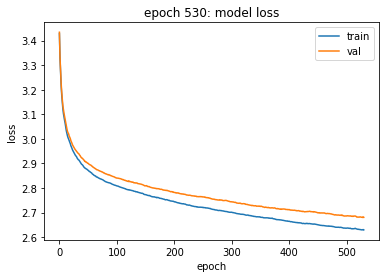

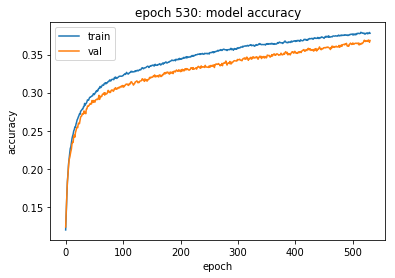



Epoch 531/600 ...........
Loss train: 2.629470092587768 
Loss val: 2.679863904662644 
Train accuracy :  0.3779 
Validation accuracy :  0.3676
Alpha:  0.5


Epoch 532/600 ...........
Loss train: 2.630043680405463 
Loss val: 2.6799764685233125 
Train accuracy :  0.37835 
Validation accuracy :  0.3692
Alpha:  0.5


Epoch 533/600 ...........
Loss train: 2.628688113385899 
Loss val: 2.678614058027706 
Train accuracy :  0.378825 
Validation accuracy :  0.3684
Alpha:  0.5


Epoch 534/600 ...........
Loss train: 2.6290237324828296 
Loss val: 2.6788190739707285 
Train accuracy :  0.379025 
Validation accuracy :  0.3681
Alpha:  0.5


Epoch 535/600 ...........
Loss train: 2.6290656609400327 
Loss val: 2.6794779418792687 
Train accuracy :  0.3798 
Validation accuracy :  0.3685
Alpha:  0.5


Epoch 536/600 ...........
Loss train: 2.6294859680971427 
Loss val: 2.680094285884382 
Train accuracy :  0.37915 
Validation accuracy :  0.3706
Alpha:  0.5


Epoch 537/600 ...........
Loss train: 2.6290123538

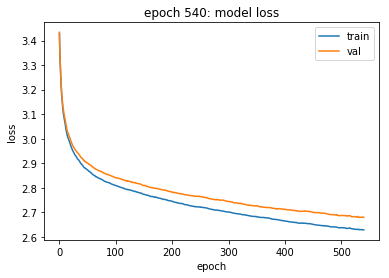

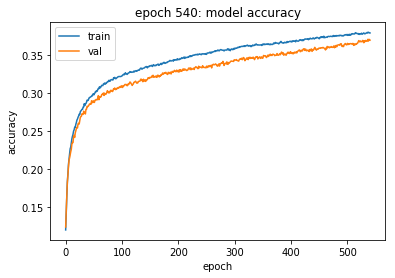



Epoch 541/600 ...........
Loss train: 2.6284840003452876 
Loss val: 2.6796621253263373 
Train accuracy :  0.379875 
Validation accuracy :  0.3691
Alpha:  0.5


Epoch 542/600 ...........
Loss train: 2.6280615026412297 
Loss val: 2.6787365850244553 
Train accuracy :  0.379975 
Validation accuracy :  0.3683
Alpha:  0.5


Epoch 543/600 ...........
Loss train: 2.628378591072959 
Loss val: 2.6794434437217776 
Train accuracy :  0.379575 
Validation accuracy :  0.37
Alpha:  0.5


Epoch 544/600 ...........
Loss train: 2.627542338922459 
Loss val: 2.6784552063453293 
Train accuracy :  0.3797 
Validation accuracy :  0.3696
Alpha:  0.5


Epoch 545/600 ...........
Loss train: 2.6277145059246423 
Loss val: 2.677812474290099 
Train accuracy :  0.379875 
Validation accuracy :  0.3691
Alpha:  0.5


Epoch 546/600 ...........
Loss train: 2.6263573178025466 
Loss val: 2.676631955188223 
Train accuracy :  0.380425 
Validation accuracy :  0.3695
Alpha:  0.5


Epoch 547/600 ...........
Loss train: 2.626595

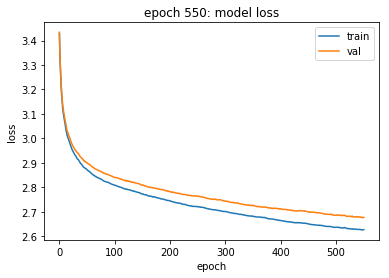

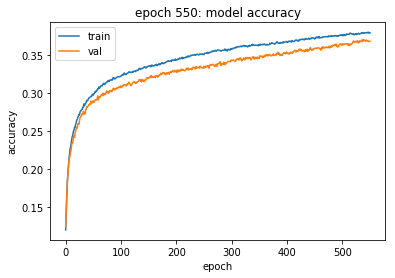



Epoch 551/600 ...........
Loss train: 2.6271239994766087 
Loss val: 2.677630539573698 
Train accuracy :  0.379775 
Validation accuracy :  0.3665
Alpha:  0.5


Epoch 552/600 ...........
Loss train: 2.625822789792223 
Loss val: 2.6767582639226033 
Train accuracy :  0.38035 
Validation accuracy :  0.3677
Alpha:  0.5


Epoch 553/600 ...........
Loss train: 2.6267944659496445 
Loss val: 2.6772462130401347 
Train accuracy :  0.38005 
Validation accuracy :  0.3691
Alpha:  0.5


Epoch 554/600 ...........
Loss train: 2.625532405198847 
Loss val: 2.6763871908959267 
Train accuracy :  0.3799 
Validation accuracy :  0.369
Alpha:  0.5


Epoch 555/600 ...........
Loss train: 2.624198296387195 
Loss val: 2.675319513457187 
Train accuracy :  0.38055 
Validation accuracy :  0.3682
Alpha:  0.5


Epoch 556/600 ...........
Loss train: 2.623342367069047 
Loss val: 2.67578470386642 
Train accuracy :  0.3808 
Validation accuracy :  0.3666
Alpha:  0.5


Epoch 557/600 ...........
Loss train: 2.62315704158347

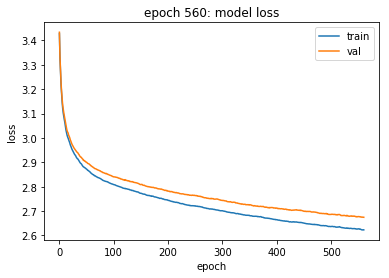

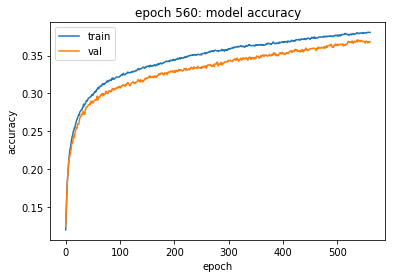



Epoch 561/600 ...........
Loss train: 2.6240904306060355 
Loss val: 2.676110831303362 
Train accuracy :  0.381025 
Validation accuracy :  0.3674
Alpha:  0.5


Epoch 562/600 ...........
Loss train: 2.6232585510907964 
Loss val: 2.6751020035445103 
Train accuracy :  0.380275 
Validation accuracy :  0.3677
Alpha:  0.5


Epoch 563/600 ...........
Loss train: 2.622475588021579 
Loss val: 2.674046990345249 
Train accuracy :  0.381575 
Validation accuracy :  0.3705
Alpha:  0.5


Epoch 564/600 ...........
Loss train: 2.6225679274173994 
Loss val: 2.6736798330264357 
Train accuracy :  0.37985 
Validation accuracy :  0.3689
Alpha:  0.5


Epoch 565/600 ...........
Loss train: 2.622220193524019 
Loss val: 2.6744988750348826 
Train accuracy :  0.3808 
Validation accuracy :  0.3675
Alpha:  0.5


Epoch 566/600 ...........
Loss train: 2.6206291197211553 
Loss val: 2.672950015442594 
Train accuracy :  0.381475 
Validation accuracy :  0.3678
Alpha:  0.5


Epoch 567/600 ...........
Loss train: 2.620397

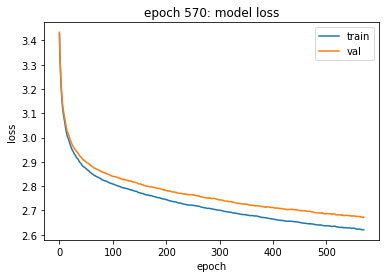

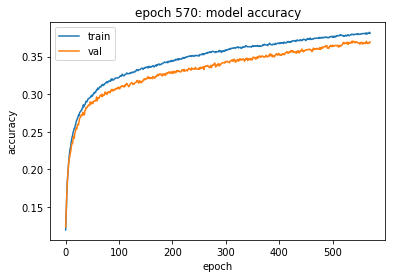



Epoch 571/600 ...........
Loss train: 2.619754597466672 
Loss val: 2.671571585186024 
Train accuracy :  0.38135 
Validation accuracy :  0.3691
Alpha:  0.5


Epoch 572/600 ...........
Loss train: 2.6198438507832695 
Loss val: 2.6721172494317247 
Train accuracy :  0.381325 
Validation accuracy :  0.3674
Alpha:  0.5


Epoch 573/600 ...........
Loss train: 2.61943651916443 
Loss val: 2.6712033993434128 
Train accuracy :  0.381125 
Validation accuracy :  0.3672
Alpha:  0.5


Epoch 574/600 ...........
Loss train: 2.6194110258956496 
Loss val: 2.6716153950827444 
Train accuracy :  0.3821 
Validation accuracy :  0.3668
Alpha:  0.5


Epoch 575/600 ...........
Loss train: 2.6191661802081176 
Loss val: 2.671118170011473 
Train accuracy :  0.381675 
Validation accuracy :  0.3692
Alpha:  0.5


Epoch 576/600 ...........
Loss train: 2.618764758483353 
Loss val: 2.6708709571026437 
Train accuracy :  0.3814 
Validation accuracy :  0.3682
Alpha:  0.5


Epoch 577/600 ...........
Loss train: 2.619404598

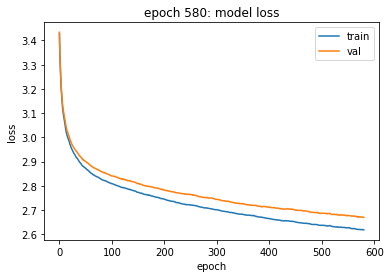

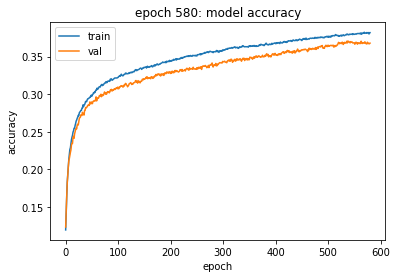



Epoch 581/600 ...........
Loss train: 2.617634750364484 
Loss val: 2.669166966361281 
Train accuracy :  0.3821 
Validation accuracy :  0.3696
Alpha:  0.5


Epoch 582/600 ...........
Loss train: 2.6173245087486245 
Loss val: 2.6687633564618363 
Train accuracy :  0.381375 
Validation accuracy :  0.3684
Alpha:  0.5


Epoch 583/600 ...........
Loss train: 2.6179871971601014 
Loss val: 2.6688086385837217 
Train accuracy :  0.380875 
Validation accuracy :  0.3684
Alpha:  0.5


Epoch 584/600 ...........
Loss train: 2.617410574300561 
Loss val: 2.6685712591561437 
Train accuracy :  0.381275 
Validation accuracy :  0.3685
Alpha:  0.5


Epoch 585/600 ...........
Loss train: 2.617156097407279 
Loss val: 2.668109833879719 
Train accuracy :  0.381825 
Validation accuracy :  0.3711
Alpha:  0.5


Epoch 586/600 ...........
Loss train: 2.6169606087943387 
Loss val: 2.668113142165851 
Train accuracy :  0.3818 
Validation accuracy :  0.3716
Alpha:  0.5


Epoch 587/600 ...........
Loss train: 2.61707657

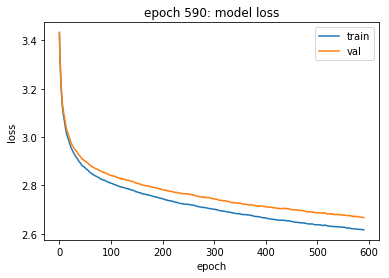

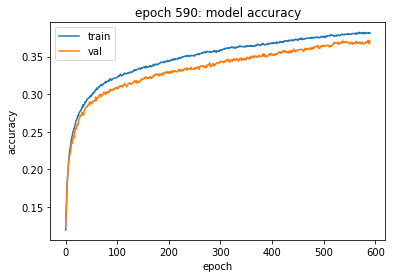



Epoch 591/600 ...........
Loss train: 2.6154231970982984 
Loss val: 2.6664715781933728 
Train accuracy :  0.381125 
Validation accuracy :  0.3691
Alpha:  0.5


Epoch 592/600 ...........
Loss train: 2.6155407114174793 
Loss val: 2.6662305718789034 
Train accuracy :  0.381875 
Validation accuracy :  0.3695
Alpha:  0.5


Epoch 593/600 ...........
Loss train: 2.616829442545982 
Loss val: 2.66911551554648 
Train accuracy :  0.38225 
Validation accuracy :  0.3722
Alpha:  0.5


Epoch 594/600 ...........
Loss train: 2.615909020968529 
Loss val: 2.666222017856868 
Train accuracy :  0.38215 
Validation accuracy :  0.3717
Alpha:  0.5


Epoch 595/600 ...........
Loss train: 2.6156488482225972 
Loss val: 2.6671401984670893 
Train accuracy :  0.381775 
Validation accuracy :  0.3722
Alpha:  0.5


Epoch 596/600 ...........
Loss train: 2.6149819520639865 
Loss val: 2.6663014581583693 
Train accuracy :  0.383075 
Validation accuracy :  0.3716
Alpha:  0.5


Epoch 597/600 ...........
Loss train: 2.61430

In [236]:
batch_size = 1000
dropout_prob = 0.5
num_epochs = 600
alpha = 1
#np.random.seed(0)
history_loss_train,history_loss_val, history_acc_train, history_acc_val = [],[],[],[]
num_train_samples = x_train.shape[0]
num_batches = num_train_samples // batch_size
layers_size = [3072,64, 128, 32, 10]
thetas = np.asarray([np.random.randn(layers_size[i], layers_size[i+1]) for i in range(0, len(layers_size)-1)])
y_pred = forward(thetas, x_train,dropout_prob, False)
loss_val = loss(y_train, y_pred[-1])
print("Initial loss :", loss_val)
Et = np.asarray([np.ones(th.shape) for th in thetas])
for i in range(0, num_epochs):
    p = np.random.permutation(num_train_samples)
    print('\n\nEpoch %d/%d ' % (i, num_epochs), end='.')
    for batch_no in range(0, num_batches):
        if np.mod(batch_no, num_batches // 10) == 0:
            print('.', end='')
            sys.stdout.flush()
        
        x_train_batch = x_train[p[batch_no * batch_size : (batch_no + 1) * batch_size], :]
        y_train_batch = y_train[p[batch_no * batch_size: (batch_no + 1) * batch_size]]
        d_theta = backward(x_train_batch, y_train_batch, thetas,dropout_prob)
        
        for j in range(0,len(d_theta)):
            Et[j] = RSMprob(Et[j], d_theta[j], 0.9, alpha, 10)
            #thetas[j] =thetas[j] - alpha*d_theta[j] #Обычный mini-batch BackProp
            thetas[j] =thetas[j] - Et[j] 
  
    #loss train
    pred_train_probs = forward(thetas, x_train,dropout_prob, False)
    y_train_out = pred_train_probs[-1]
    loss_train = loss(y_train,  y_train_out)
    history_loss_train.append(loss_train)
    
    #loss val
    pred_val_probs = forward(thetas, x_val,dropout_prob, False)
    y_val_out = pred_val_probs[-1]
    loss_val = loss(y_val, y_val_out)
    history_loss_val.append(loss_val)
    
    history_acc_train.append(acc(y_train, y_train_out))
    history_acc_val.append(acc(y_val, y_val_out))
    print("\nLoss train:", loss_train,
          "\nLoss val:", loss_val,
          "\nTrain accuracy : ",acc(y_train, y_train_out),
          "\nValidation accuracy : ", acc(y_val, y_val_out))
    print("Alpha: ", alpha)
    alpha = max(0.5, alpha * 0.99)#изменение шага градиента (сначала идем большими, постепенно уменьшая)
    if np.mod(i, num_epochs // (num_epochs/10)) == 0:#каждые 10 выводим на экран
        plt.plot(history_loss_train)
        plt.plot(history_loss_val)
        plt.title(f'epoch {i}: model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

        plt.plot(history_acc_train)
        plt.plot(history_acc_val)
        plt.title(f'epoch {i}: model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()


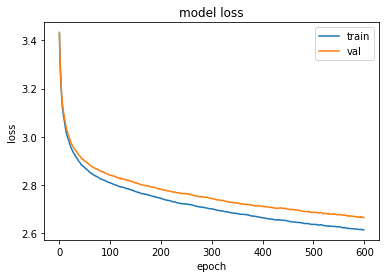

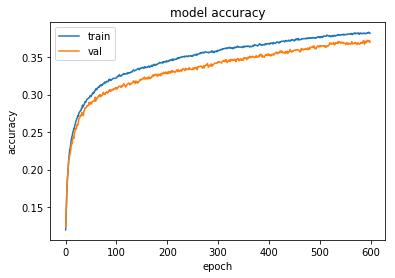

In [239]:
plt.plot(history_loss_train)
plt.plot(history_loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history_acc_train)
plt.plot(history_acc_val)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [240]:
pred_test_probs = forward(thetas, x_test,dropout_prob, False)
y_test_out = pred_test_probs[-1]
loss_test = loss(y_test, y_test_out)
print("\nLoss test:", loss_test,
          "\nTest accuracy : ",acc(y_test, y_test_out))


Loss test: 2.631775225988133 
Test accuracy :  0.3806


In [241]:
import pickle
pickle.dump(thetas, open('thetasTwoHidLay64-128-32_RSMprob_500epochs.pkl', 'wb'))